# Giới thiệu Bài toán và Bộ dữ liệu


In [1]:
import scipy
import numpy
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from math import nan
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor



## Bài toán
> **Dự đoán giá xe ô tô cũ** qua các thông tin đã cho bằng cách tối ưu, so sánh các mô hình Linear Regression, Multi-layer Perceptron



## Bộ dữ liệu
> [**DVM-Car Dataset**](https://deepvisualmarketing.github.io/) /  
-- folder [**Sale and Specification Data**](https://figshare.com/articles/figure/DVM-CAR_Dataset/19586296/2?file=38754867) /  
---- file **Ad_table (extra).csv**: cung cấp thông tin không phải hình ảnh về hơn 250 000 chiếc xe cũ được quảng cáo rao bán

### Thông tin bộ dữ liệu

```
268255 mẫu, 24 đặc trưng/mẫu

Maker: tên nhà sản xuất
Gen_model: tên thế hệ của xe
Adv_ID: ID của quảng cáo
Adv_year: ngày đăng quảng cáo
Adv_month: tháng đăng quảng cáo
Color: màu xe
Reg_year: năm đăng ký xe
Bodytype: mẫu thân xe
Runned_Miles: số km đã chạy
Engine_size: dung tích động cơ
Gearbox: loại hộp số
Fuel_type: loại nhiên liệu
Price: giá xe
Engine_power: công suất động cơ
Annual_tax: thuế hàng năm
Wheelbase: chiều dài trục cơ sở
Height: chiều cao xe
Width: chiều rộng xe
Length: chiều dài xe
Average_mpg: mức tiêu thụ nhiên liệu trung bình (miles per gallon)
Top_speed: tốc độ tối đa của xe
Seat_num: số ghế ngồi
Door_num: số cửa xe
```

# Quá trình xây dựng mô hình

## I) Giai đoạn pre-modeling

### 0) Import thư viện

In [2]:
!pip install category_encoders

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### 1) Đọc dữ liệu và chia dữ liệu

In [4]:
filepath = '../car-dataset.csv'

In [5]:
def load_dataframe (filepath):
  return pd.read_csv(filepath)

df = load_dataframe(filepath)

Ta thấy thứ tự các dòng của bộ dữ liệu được sắp xếp theo một trình tự trước đó (eg: xếp theo thứ tự từ điển theo cột Maker và Genmode).  
Điều này không tốt cho việc chia thành các tập dữ liệu và có thể dẫn đến việc mô hình bị bias

==> Giải pháp: SHUFFLE các dòng trước khi chia

In [6]:
df.head()

,Maker,Genmodel,Genmodel_ID,Adv_ID,Adv_year,Adv_month,Color,Reg_year,Bodytype,Runned_Miles,...,Engine_power,Annual_Tax,Wheelbase,Height,Width,Length,Average_mpg,Top_speed,Seat_num,Door_num
0,Bentley,Arnage,10_1,10_1$$1,2018,4,Silver,2000.0,Saloon,60000,...,NaN,NaN,3116.0,1515.0,2125.0,5390.0,NaN,NaN,5.0,4.0
1,Bentley,Arnage,10_1,10_1$$2,2018,6,Grey,2002.0,Saloon,44000,...,450.0,315,3116.0,1515.0,2125.0,5390.0,13.7 mpg,179 mph,5.0,4.0
2,Bentley,Arnage,10_1,10_1$$3,2017,11,Blue,2002.0,Saloon,55000,...,400.0,315,3116.0,1515.0,2125.0,5390.0,14.7 mpg,155 mph,5.0,4.0
3,Bentley,Arnage,10_1,10_1$$4,2018,4,Green,2003.0,Saloon,14000,...,NaN,NaN,3116.0,1515.0,2125.0,5390.0,NaN,NaN,5.0,4.0
4,Bentley,Arnage,10_1,10_1$$5,2017,11,Grey,2003.0,Saloon,61652,...,NaN,NaN,3116.0,1515.0,2125.0,5390.0,NaN,NaN,5.0,4.0


In [7]:
def shuffle_rows (dataframe):
  return dataframe.sample(frac=1, random_state = 2).reset_index(drop=True)

df = shuffle_rows(df)
df.head()

,Maker,Genmodel,Genmodel_ID,Adv_ID,Adv_year,Adv_month,Color,Reg_year,Bodytype,Runned_Miles,...,Engine_power,Annual_Tax,Wheelbase,Height,Width,Length,Average_mpg,Top_speed,Seat_num,Door_num
0,Mercedes-Benz,GLE Class,59_25,59_25$$373,2021,5,White,2019.0,Coupe,4987,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0
1,Vauxhall,Corsa,94_9,94_9$$3352,2018,8,Black,2015.0,Hatchback,35345,...,94.0,0,2510.0,1481.0,1944.0,4021.0,83.1 mpg,113 mph,5.0,5.0
2,Nissan,350 Z,64_1,64_1$$57,2018,8,NaN,2005.0,Coupe,64000,...,276.0,NaN,2650.0,1320.0,1815.0,4310.0,24.8 mpg,155 mph,2.0,2.0
3,Ford,Fiesta,29_13,29_13$$1409,2018,8,Blue,2007.0,Hatchback,104155,...,NaN,250,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0
4,Ford,C-Max,29_2,29_2$$689,2018,5,Black,2012.0,MPV,71000,...,113.0,30,2850.0,1626.0,2067.0,4380.0,61.4 mpg,114 mph,5.0,5.0


In [8]:
del df

In [9]:
def get_car_data(ratio = (0.8, 0.1, 0.1)): # filetype: .csv | list_type: pandas dataframe | ratio: (train - val - test)
  # tập train lớn nên chọn 8 1 1
  data = load_dataframe(filepath)
  data = shuffle_rows(data)

  data_x = data.drop(columns=['Price'])
  data_y = data['Price']

  train_size = int(len(data) * ratio[0])
  val_size = int(len(data) * ratio[1])
  test_size = int(len(data) * ratio[2])

  x_train = data_x[:train_size]
  y_train = data_y[:train_size]

  x_val = data_x[train_size:train_size+val_size]
  y_val = data_y[train_size:train_size+val_size]

  x_test = data_x[train_size+val_size:]
  y_test = data_y[train_size+val_size:]


  return x_train, y_train, x_val, y_val, x_test, y_test

In [10]:
x_train, y_train, x_val, y_val, x_test, y_test = get_car_data()

In [11]:
x_train.head()

,Maker,Genmodel,Genmodel_ID,Adv_ID,Adv_year,Adv_month,Color,Reg_year,Bodytype,Runned_Miles,...,Engine_power,Annual_Tax,Wheelbase,Height,Width,Length,Average_mpg,Top_speed,Seat_num,Door_num
0,Mercedes-Benz,GLE Class,59_25,59_25$$373,2021,5,White,2019.0,Coupe,4987,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0
1,Vauxhall,Corsa,94_9,94_9$$3352,2018,8,Black,2015.0,Hatchback,35345,...,94.0,0,2510.0,1481.0,1944.0,4021.0,83.1 mpg,113 mph,5.0,5.0
2,Nissan,350 Z,64_1,64_1$$57,2018,8,NaN,2005.0,Coupe,64000,...,276.0,NaN,2650.0,1320.0,1815.0,4310.0,24.8 mpg,155 mph,2.0,2.0
3,Ford,Fiesta,29_13,29_13$$1409,2018,8,Blue,2007.0,Hatchback,104155,...,NaN,250,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0
4,Ford,C-Max,29_2,29_2$$689,2018,5,Black,2012.0,MPV,71000,...,113.0,30,2850.0,1626.0,2067.0,4380.0,61.4 mpg,114 mph,5.0,5.0


In [12]:
y_train.head()

0    50810.0
1     7500.0
2     5995.0
3     2180.0
4     5995.0
Name: Price, dtype: float64

### 2) Làm sạch nhẹ dữ liệu

In [13]:
x_train.head()

,Maker,Genmodel,Genmodel_ID,Adv_ID,Adv_year,Adv_month,Color,Reg_year,Bodytype,Runned_Miles,...,Engine_power,Annual_Tax,Wheelbase,Height,Width,Length,Average_mpg,Top_speed,Seat_num,Door_num
0,Mercedes-Benz,GLE Class,59_25,59_25$$373,2021,5,White,2019.0,Coupe,4987,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0
1,Vauxhall,Corsa,94_9,94_9$$3352,2018,8,Black,2015.0,Hatchback,35345,...,94.0,0,2510.0,1481.0,1944.0,4021.0,83.1 mpg,113 mph,5.0,5.0
2,Nissan,350 Z,64_1,64_1$$57,2018,8,NaN,2005.0,Coupe,64000,...,276.0,NaN,2650.0,1320.0,1815.0,4310.0,24.8 mpg,155 mph,2.0,2.0
3,Ford,Fiesta,29_13,29_13$$1409,2018,8,Blue,2007.0,Hatchback,104155,...,NaN,250,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0
4,Ford,C-Max,29_2,29_2$$689,2018,5,Black,2012.0,MPV,71000,...,113.0,30,2850.0,1626.0,2067.0,4380.0,61.4 mpg,114 mph,5.0,5.0


Ta thấy dữ liệu thô vẫn có rất nhiều cột mà các giá trị được viết theo kiểu: [số] + [ký tự không phải số], kể đến như  

- 'L' trên cột Engine_size
- 'mpg' trên cột Average_mpg
- 'mph' trên Top_speed
- dấu sao trên cột Annual_tax
- Runned_Miles có các datatype là "object"

Để thuận tiện hơn cho việc EDA, ta sẽ thực hiện loại bỏ ký tự chữ ở các ô trên và chuyển ô sang dạng float64

In [14]:
continuous_cols = ['Engine_size', 'Average_mpg', "Top_speed", "Annual_Tax", "Runned_Miles", "Engine_power", "Wheelbase", "Height", "Length", "Width", "Seat_num", "Door_num"]


def light_data_cleaning(df, cols=[]):
    numeric_cols = cols
    for col in numeric_cols:
        if col in df.columns:
            df[col] = df[col].astype(str).str.extract(r'(\d+(?:\.\d+)?)')[0]
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df



In [15]:

x_train = light_data_cleaning(x_train, continuous_cols)
x_val = light_data_cleaning(x_val, continuous_cols)
x_test = light_data_cleaning(x_test, continuous_cols)

x_train.head(10)

,Maker,Genmodel,Genmodel_ID,Adv_ID,Adv_year,Adv_month,Color,Reg_year,Bodytype,Runned_Miles,...,Engine_power,Annual_Tax,Wheelbase,Height,Width,Length,Average_mpg,Top_speed,Seat_num,Door_num
0,Mercedes-Benz,GLE Class,59_25,59_25$$373,2021,5,White,2019.0,Coupe,4987.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0
1,Vauxhall,Corsa,94_9,94_9$$3352,2018,8,Black,2015.0,Hatchback,35345.0,...,94.0,0.0,2510.0,1481.0,1944.0,4021.0,83.1,113.0,5.0,5.0
2,Nissan,350 Z,64_1,64_1$$57,2018,8,NaN,2005.0,Coupe,64000.0,...,276.0,NaN,2650.0,1320.0,1815.0,4310.0,24.8,155.0,2.0,2.0
3,Ford,Fiesta,29_13,29_13$$1409,2018,8,Blue,2007.0,Hatchback,104155.0,...,NaN,250.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0
4,Ford,C-Max,29_2,29_2$$689,2018,5,Black,2012.0,MPV,71000.0,...,113.0,30.0,2850.0,1626.0,2067.0,4380.0,61.4,114.0,5.0,5.0
5,Volkswagen,Sharan,95_24,95_24$$537,2018,7,Blue,2017.0,MPV,14623.0,...,148.0,140.0,2920.0,1720.0,2081.0,4854.0,54.3,123.0,7.0,5.0
6,Mazda,CX-3,57_6,57_6$$155,2018,4,NaN,2018.0,SUV,20.0,...,118.0,140.0,2570.0,1535.0,1765.0,4275.0,47.9,119.0,5.0,5.0
7,Citroen,DS3 Cabrio,21_1,21_1$$1587,2018,4,Red,2013.0,Convertible,33856.0,...,153.0,140.0,NaN,NaN,NaN,NaN,47.9,132.0,5.0,2.0
8,BMW,5 Series,8_9,8_9$$96,2018,8,Silver,2003.0,Saloon,156000.0,...,231.0,315.0,1558.0,1468.0,1846.0,4841.0,28.4,153.0,5.0,4.0
9,Audi,Q3,7_19,7_19$$202,2018,6,Grey,2017.0,SUV,9948.0,...,178.0,140.0,2603.0,1608.0,2019.0,4388.0,42.2,135.0,5.0,5.0


### 3) Khám phá dữ liệu - Exploratory Data Analysis

In [16]:
continuous_cols = ['Engine_size', 'Average_mpg', "Top_speed", "Annual_Tax", "Runned_Miles", "Engine_power", "Wheelbase", "Height", "Length", "Width", "Seat_num", "Door_num"]
discrete_cols= ['Maker', 'Genmodel', 'Genmodel_ID', 'Adv_ID', 'Adv_year', 'Adv_month', 'Color', 'Reg_year', 'Bodytype', 'Gearbox', 'Fuel_type', ]

#### **Tổng quan**

In [17]:
print("===== Kích thước dữ liệu =====")
print("")
print("x_train", np.shape(x_train))
print("x_val", np.shape(x_val))
print("x_test", np.shape(x_test))
print("")
print("y_train", np.shape(y_train))
print("y_val", np.shape(y_val))
print("y_test", np.shape(y_test))

===== Kích thước dữ liệu =====

x_train (214604, 23)
x_val (26825, 23)
x_test (26826, 23)

y_train (214604,)
y_val (26825,)
y_test (26826,)


In [18]:
print("===== Kiểu dữ liệu =====")
x_train.info()
# note: string trong pandas được biểu diễn dưới dạng object

===== Kiểu dữ liệu =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214604 entries, 0 to 214603
Data columns (total 23 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Maker         214604 non-null  object 
 1   Genmodel      214604 non-null  object 
 2   Genmodel_ID   214604 non-null  object 
 3   Adv_ID        214604 non-null  object 
 4   Adv_year      214604 non-null  int64  
 5   Adv_month     214604 non-null  int64  
 6   Color         197091 non-null  object 
 7   Reg_year      214598 non-null  float64
 8   Bodytype      213833 non-null  object 
 9   Runned_Miles  213764 non-null  float64
 10  Engine_size   212964 non-null  float64
 11  Gearbox       214472 non-null  object 
 12  Fuel_type     214281 non-null  object 
 13  Engine_power  189122 non-null  float64
 14  Annual_Tax    176467 non-null  float64
 15  Wheelbase     192149 non-null  float64
 16  Height        192310 non-null  float64
 17  Width         192085 no

In [19]:
print('===== Thống kê cơ bản (cột có dữ liệu số) =====')
x_train.describe()

===== Thống kê cơ bản (cột có dữ liệu số) =====


,Adv_year,Adv_month,Reg_year,Runned_Miles,Engine_size,Engine_power,Annual_Tax,Wheelbase,Height,Width,Length,Average_mpg,Top_speed,Seat_num,Door_num
count,214604.000000,214604.000000,214598.000000,2.137640e+05,212964.000000,189122.000000,176467.000000,192149.000000,192310.000000,192085.000000,192310.000000,180965.000000,179589.000000,209358.000000,210949.000000
mean,2018.127071,5.624280,2012.705971,4.814174e+04,1.971288,150.563867,155.924507,2564.246543,1530.749311,1896.112851,4370.918590,50.909192,122.012796,4.904193,4.371170
std,0.747469,2.093884,4.462686,4.239305e+04,10.459608,84.539370,120.762496,490.815919,164.174447,151.035665,423.704313,15.850825,18.533432,0.878550,1.009465
min,2012.000000,1.000000,1960.000000,0.000000e+00,0.100000,17.000000,0.000000,0.000000,0.000000,1191.000000,0.000000,9.400000,11.000000,1.000000,2.000000
25%,2018.000000,4.000000,2010.000000,1.407900e+04,1.400000,99.000000,30.000000,2511.000000,1456.000000,1780.000000,4081.000000,41.500000,109.000000,5.000000,4.000000
50%,2018.000000,5.000000,2014.000000,3.916000e+04,1.800000,128.000000,140.000000,2640.000000,1494.000000,1884.000000,4385.000000,50.400000,118.000000,5.000000,5.000000
75%,2018.000000,7.000000,2016.000000,7.500000e+04,2.000000,175.000000,195.000000,2752.000000,1624.000000,2020.000000,4672.000000,60.100000,130.000000,5.000000,5.000000
max,2021.000000,33.000000,2019.000000,6.363342e+06,3500.000000,740.000000,555.000000,5246.000000,2660.000000,2690.000000,6165.000000,471.000000,226.000000,17.000000,7.000000


In [20]:
y_train.astype('Int64').describe()

count        213679.0
mean     14758.787906
std      33109.944163
min             100.0
25%            4990.0
50%            9298.0
75%           17249.0
max         9999999.0
Name: Price, dtype: Float64

Ta có thể thấy vài chỗ vô lí như
- Adv_month có max là 33 (mà 1 năm 12 tháng)
- Wheelbase (độ dài trục cơ sở), Height, Length, Doornum có min là 0

In [21]:
def value_counts_all_columns(df):
    result = {}
    for col in df.columns:
        counts = df[col].value_counts(dropna=False)  # tính cả NaN
        result[col] = counts
    return result


print("Khảo sát giá trị và count của các giá trị theo cột")
value_counts_all_columns(x_train[discrete_cols])

Khảo sát giá trị và count của các giá trị theo cột


{'Maker': Maker
 Ford          21504
 Audi          18018
 Vauxhall      16106
 Volkswagen    14487
 BMW           13756
               ...  
 Daimler           1
 Pagani            1
 Radical           1
 Perodua           1
 Brooke            1
 Name: count, Length: 85, dtype: int64,
 'Genmodel': Genmodel
 Corsa         4464
 Focus         4129
 Fiesta        3800
 X5            2729
 Juke          2720
               ... 
 M600             1
 SX               1
 Noah             1
 Satria Neo       1
 Double R         1
 Name: count, Length: 865, dtype: int64,
 'Genmodel_ID': Genmodel_ID
 94_9     4464
 29_14    4129
 29_13    3800
 8_39     2729
 64_14    2720
          ... 
 83_1        1
 18_5        1
 29_11       1
 62_5        1
 12_1        1
 Name: count, Length: 850, dtype: int64,
 'Adv_ID': Adv_ID
 55_7$$2        1
 59_25$$373     1
 94_9$$3352     1
 64_1$$57       1
 29_13$$1409    1
               ..
 92_33$$11      1
 64_33$$2059    1
 59_29$$264     1
 29_23$$160     

#### Phân tích đơn biến

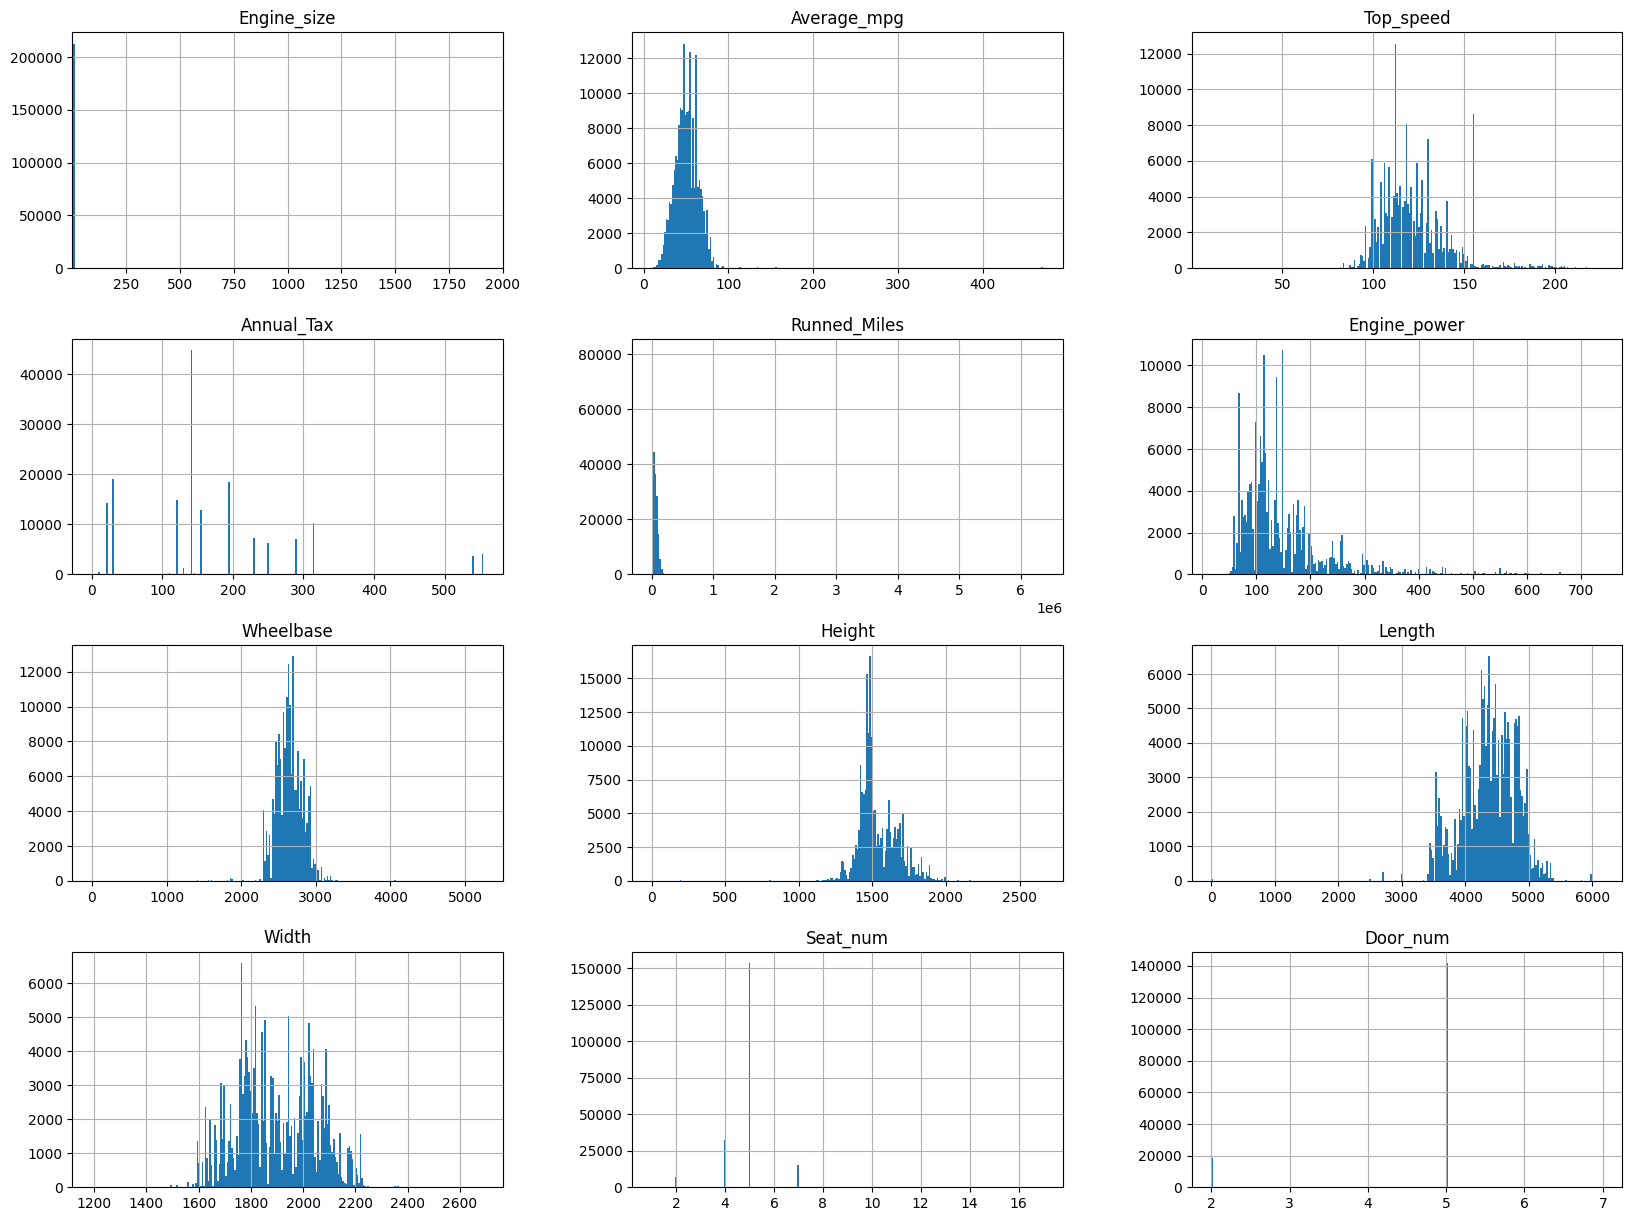

In [22]:
# HISTOGRAM
plots = x_train[continuous_cols].hist(bins=250, figsize=(20, 15))

plots[0][0].set_xlim(1, 2000)

plt.show()


- Engine power lệch phải mạnh, nhiều xe có công suất thấp
- Một số giá trị bất thường ở gần 0
- Đa số phân phối gần chuẩn hoặc lệch nhẹ
- Engine_size tập trung rất nhiều tầm 0 - 20L và có giá trị lớn bất thường
...

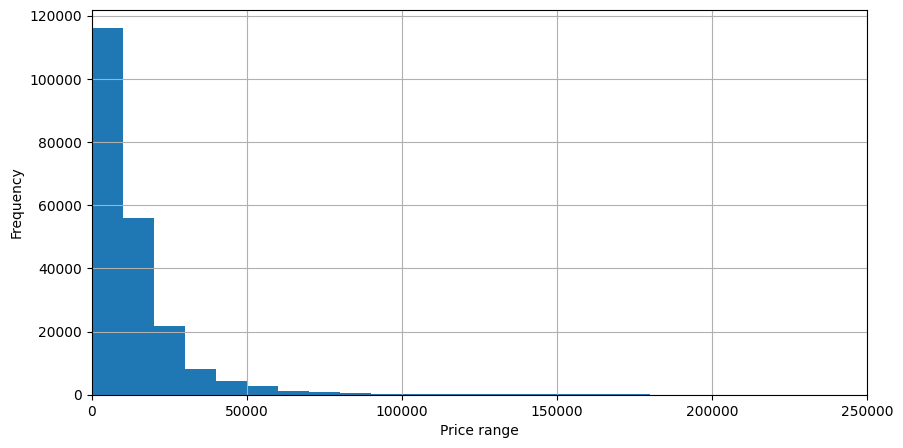

In [23]:
y_train.hist(bins=1000, figsize=(10, 5)) # Zoom kĩ sẽ thấy nhiều outliers rải rác, đó là lí do miền dữ liệu bên trái bị 'nén' lại

plt.xlim((0, 250000)) # zoom vào phân phối bên trái
plt.xlabel("Price range")
plt.ylabel("Frequency")
plt.show()

- Lệch phải cực mạnh
- Hầu hết là xe giá từ 0 => 50000
- Nhiều outliers

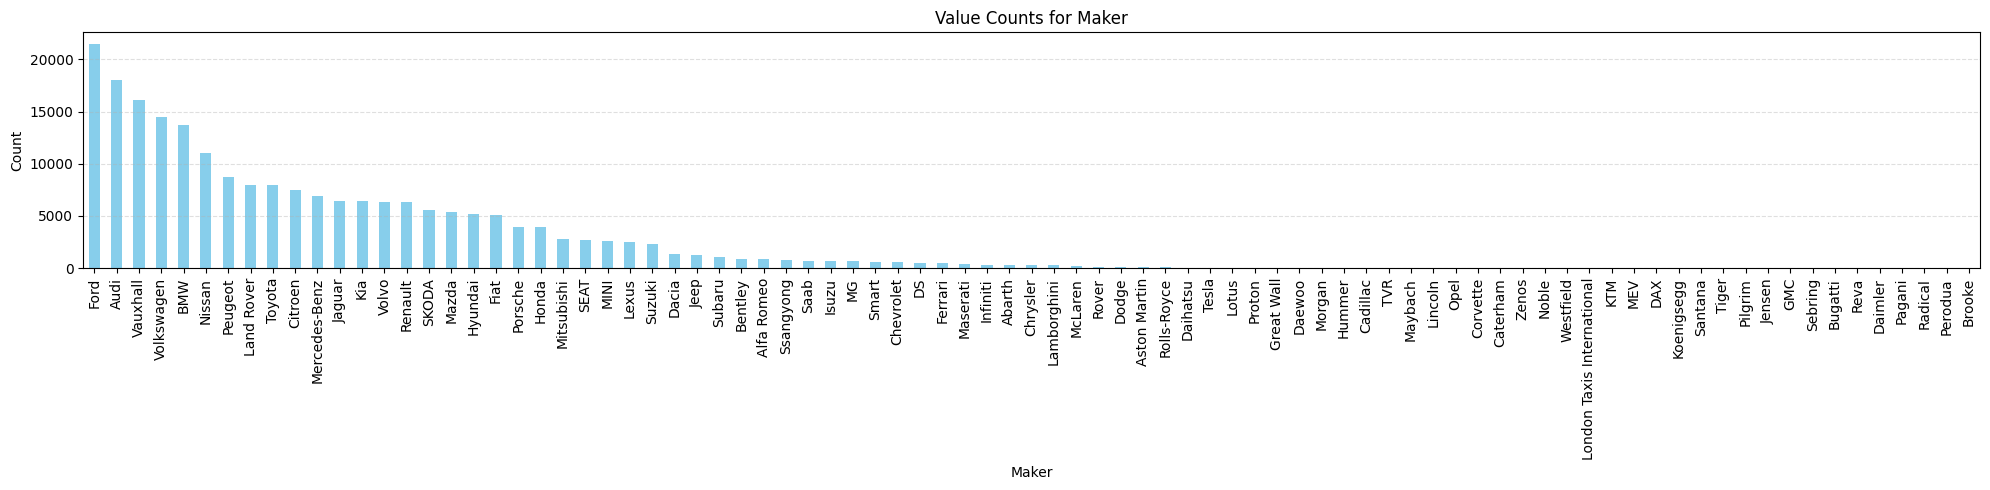

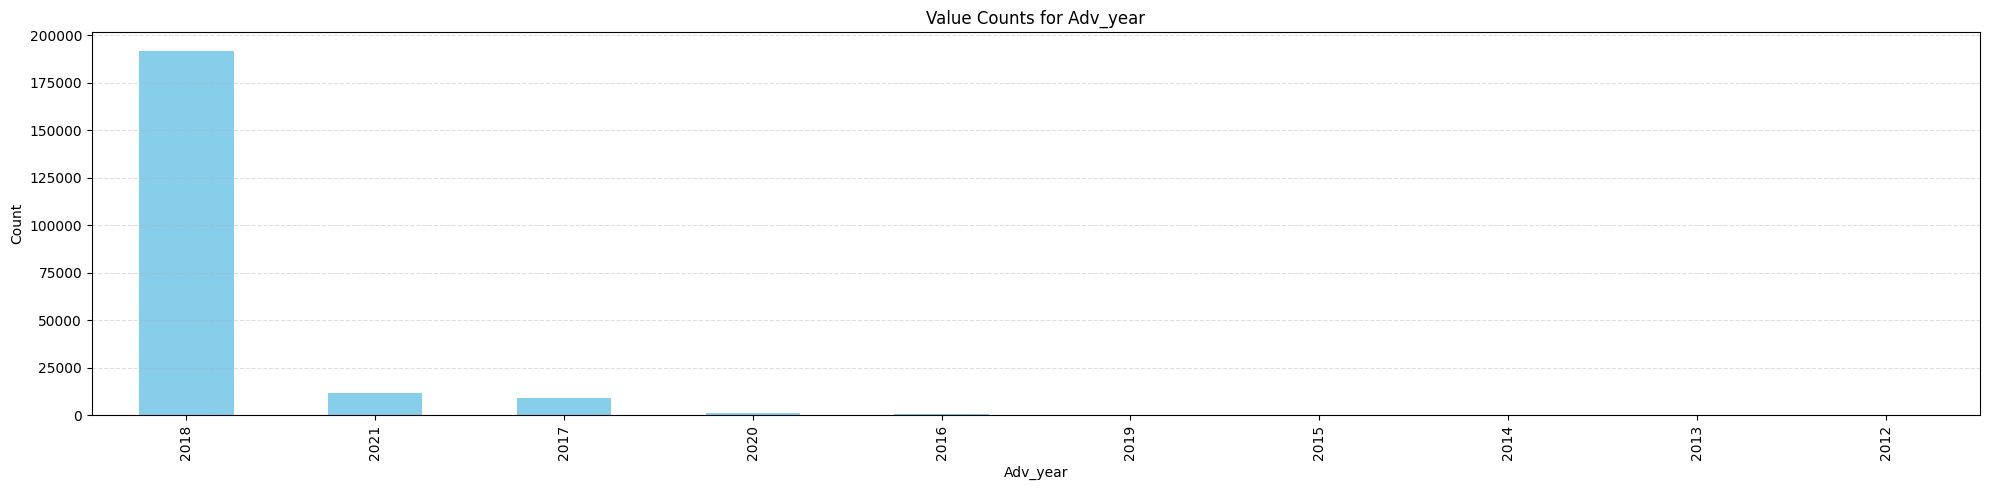

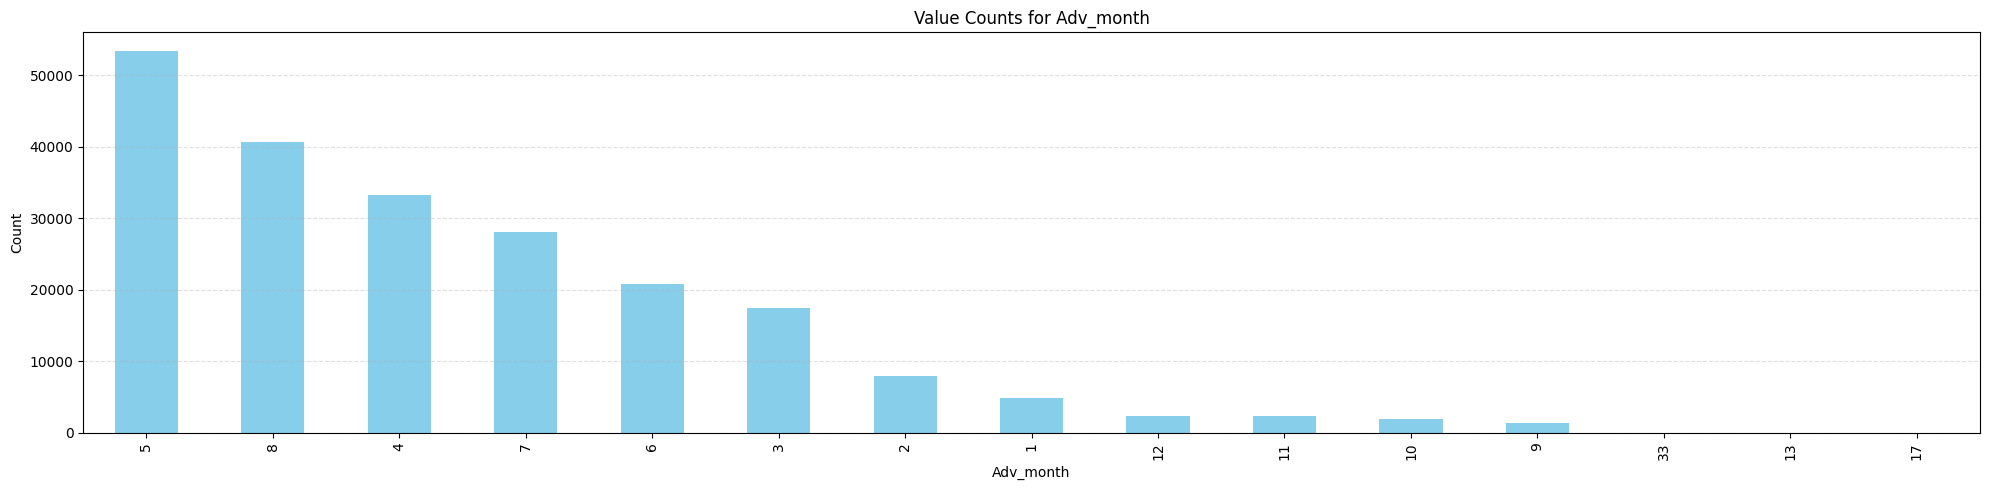

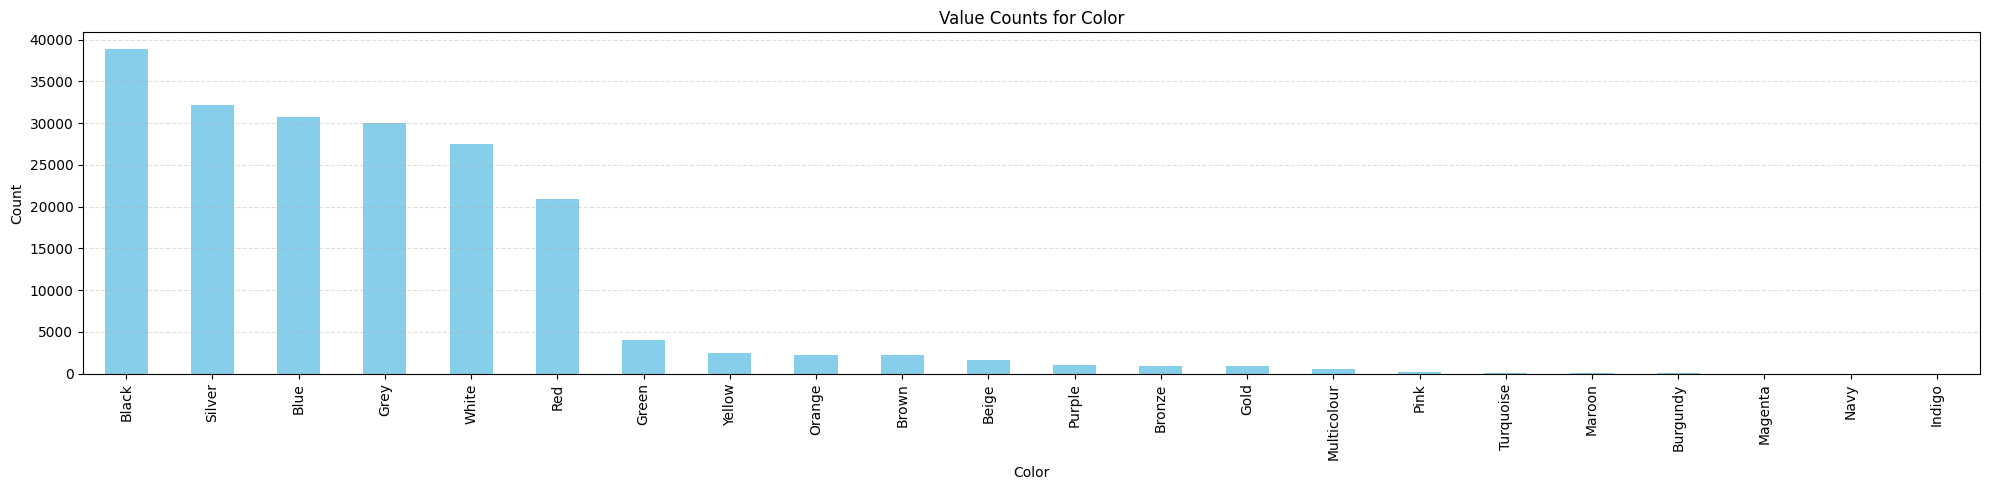

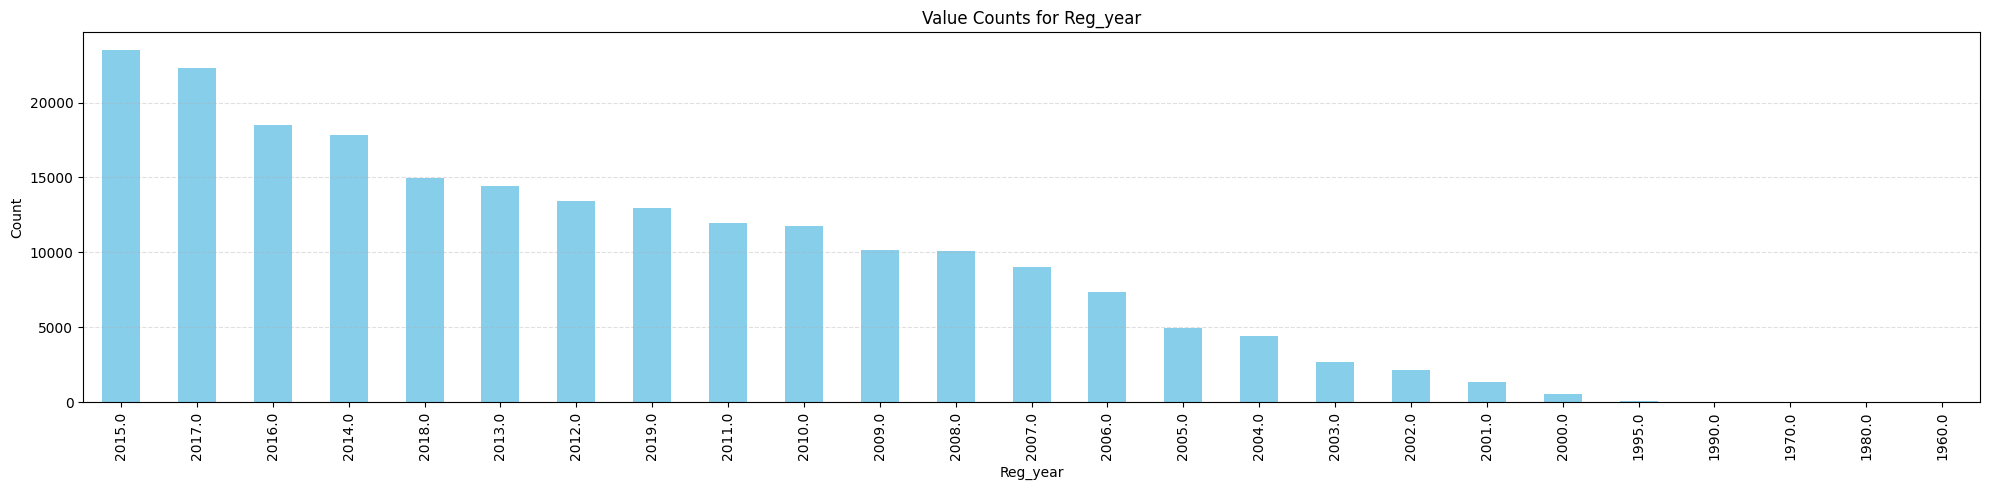

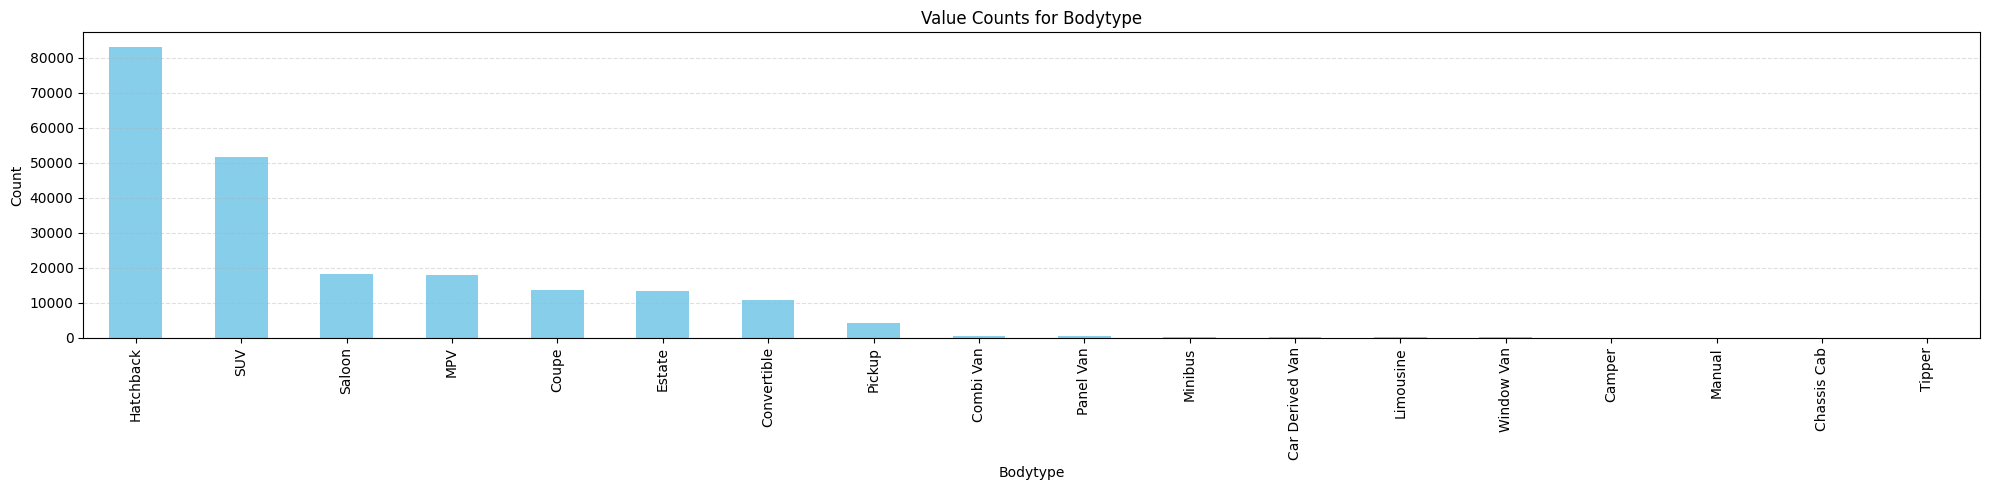

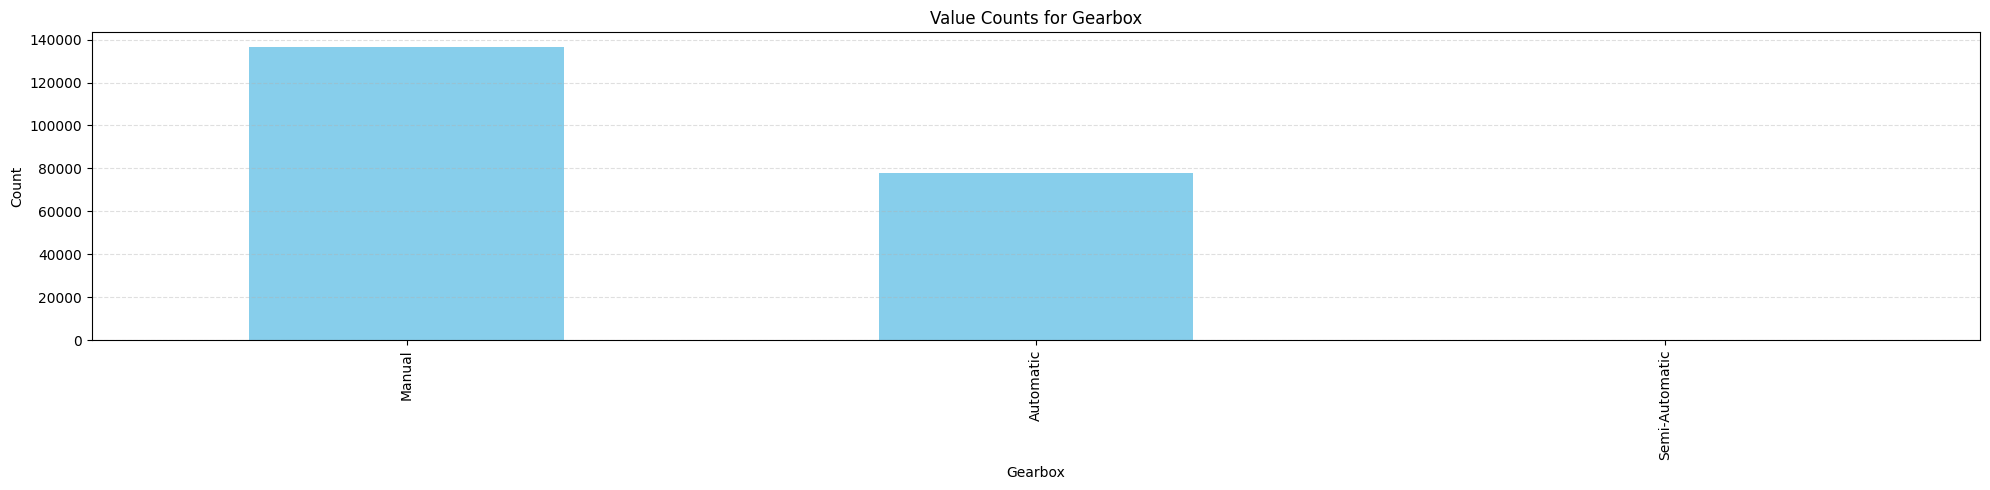

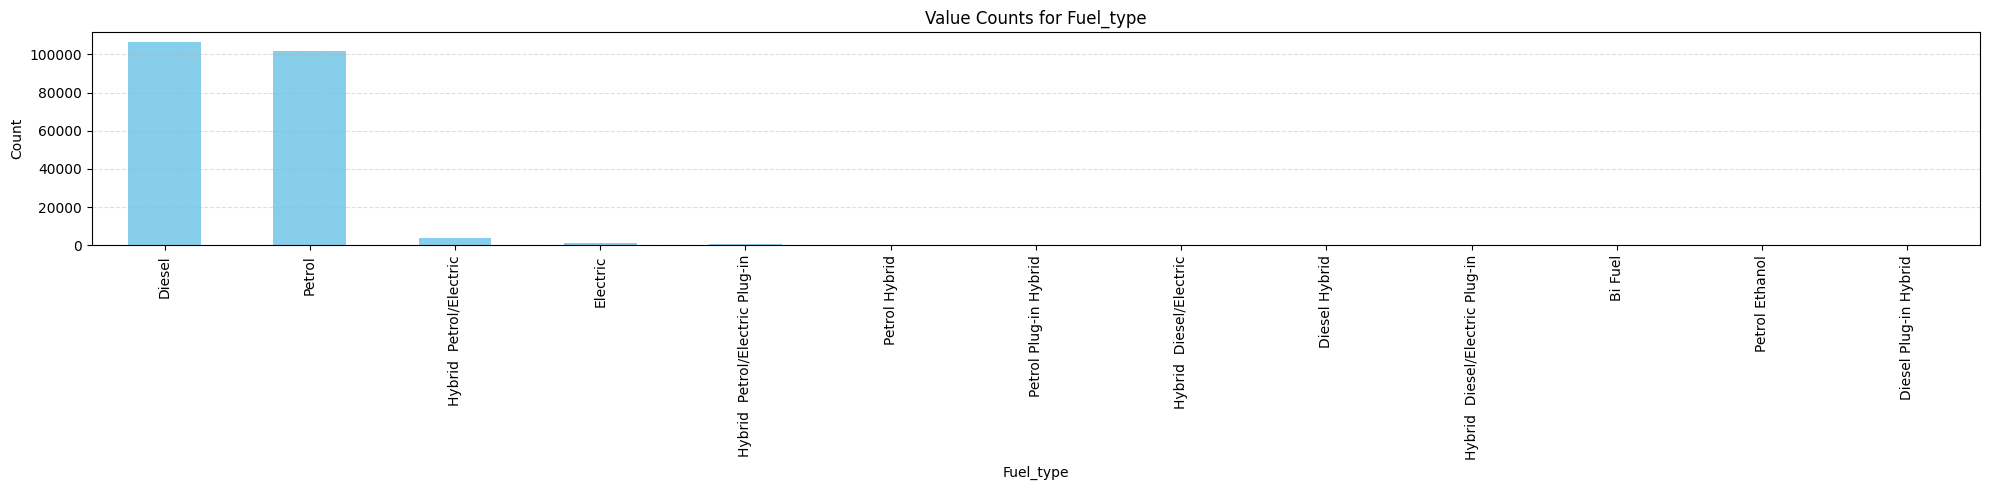

In [24]:
for col in  ['Maker', 'Adv_year', 'Adv_month', 'Color', 'Reg_year', 'Bodytype', 'Gearbox', 'Fuel_type', ]:
    plt.figure(figsize=(20, 5))
    x_train[col].value_counts().plot(kind='bar', color='skyblue')
    plt.title(f'Value Counts for {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

#### Phân tích đa biến

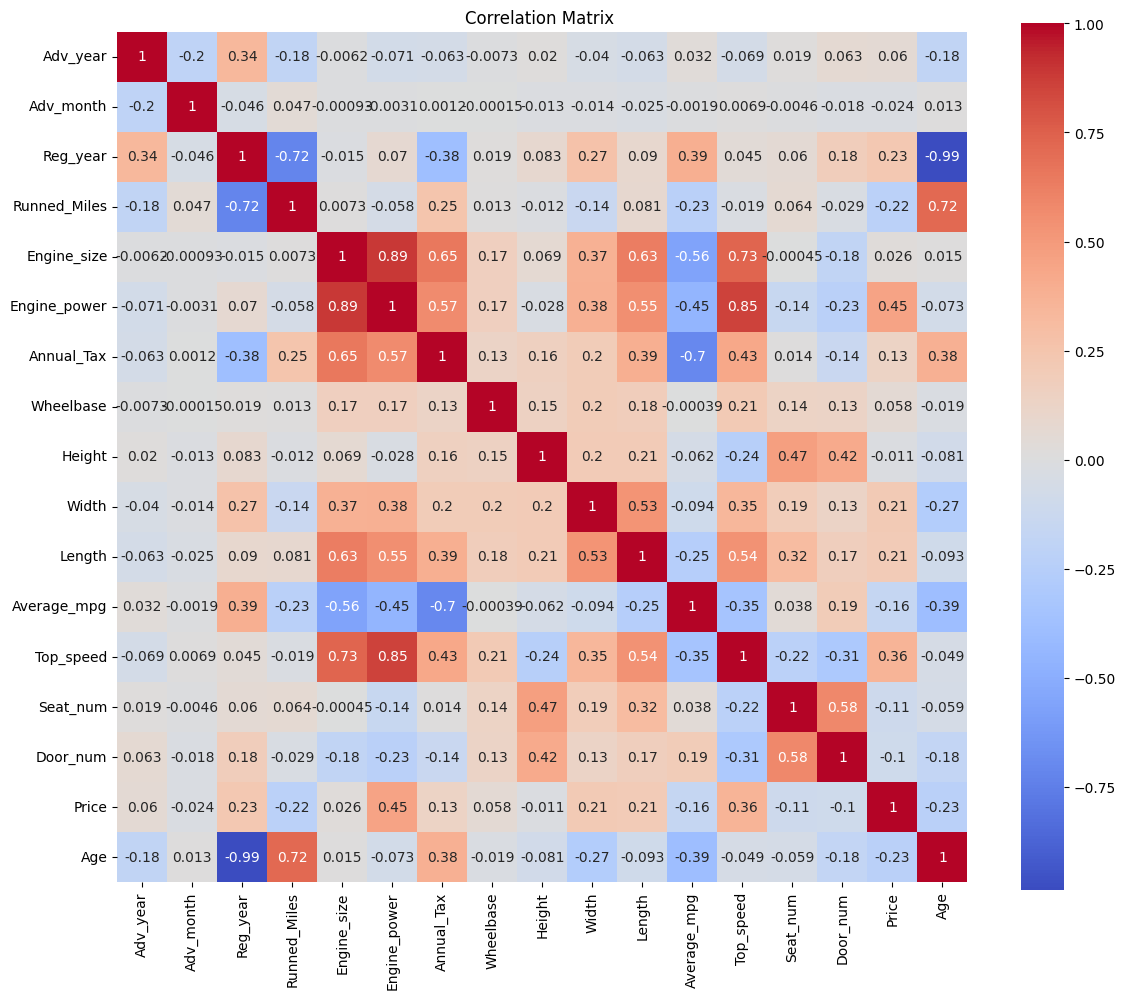

In [25]:
# Minh họa độ tương quan của cột và các đặc trưng mới
# ['Maker', 'Genmodel', 'Genmodel_ID', 'Adv_ID', 'Adv_year', 'Adv_month', 'Color', 'Reg_year', 'Bodytype', 'Runned_Miles', 'Engine_size', 'Gearbox', 'Fuel_type', 'Engine_power', 'Annual_Tax', 'Wheelbase', 'Height', 'Width', 'Length', 'Average_mpg', 'Top_speed', 'Seat_num', 'Door_num']
import seaborn as sns

tmp = x_train.select_dtypes(include=['float64', 'int64'])
tmp['Price'] = y_train.values
tmp['Age'] = tmp['Adv_year'] - tmp['Reg_year'] # đặc trưng số tuổi
# tmp['Volume'] = tmp['Height'] * tmp['Length'] * tmp['Width'] # đặc trưng số tuổi
# tmp['Save_power'] = tmp['Engine_power'] * tmp['Average_mpg'] #

corr_matrix = tmp[tmp.select_dtypes(include=['float64', 'int64']).columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Matrix ")
plt.tight_layout()
plt.show()

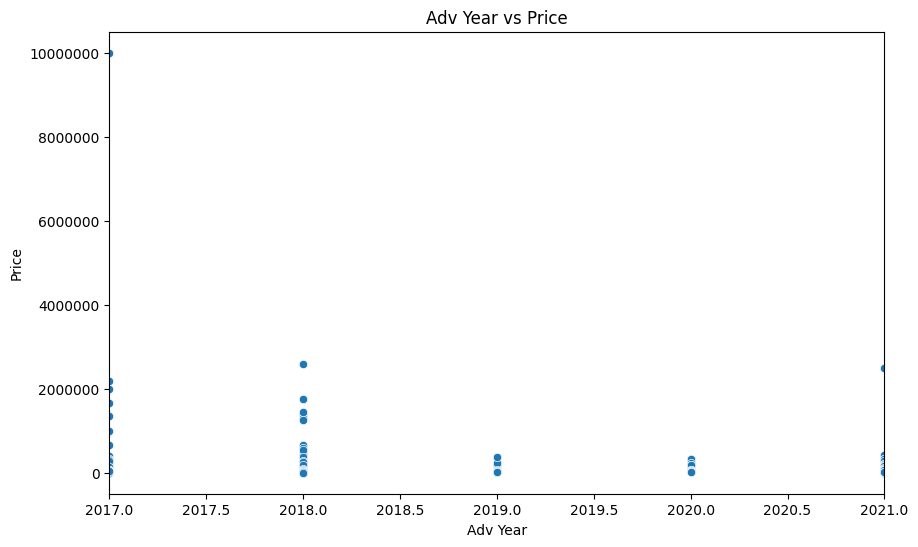

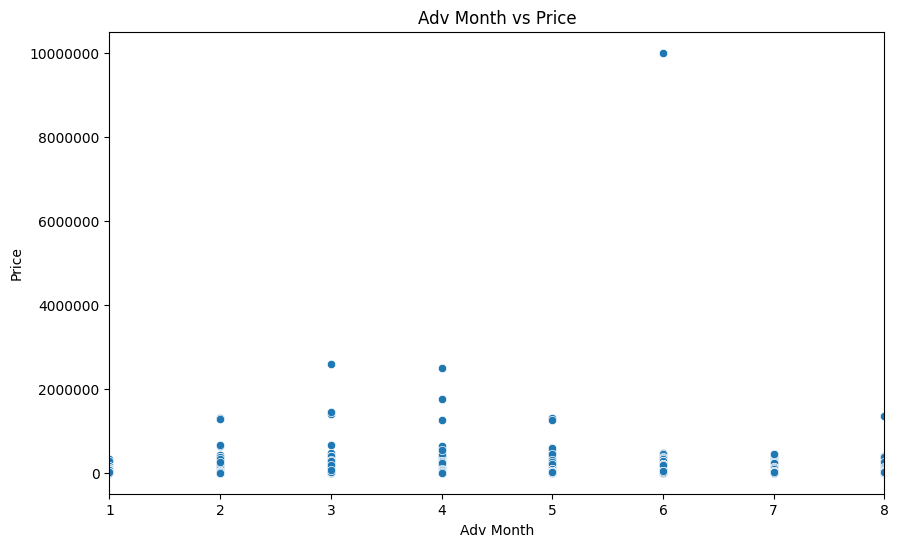

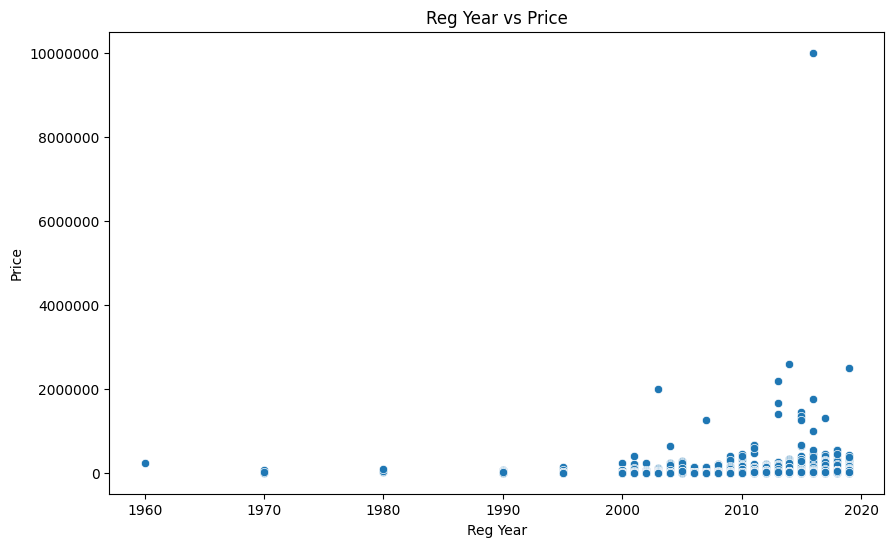

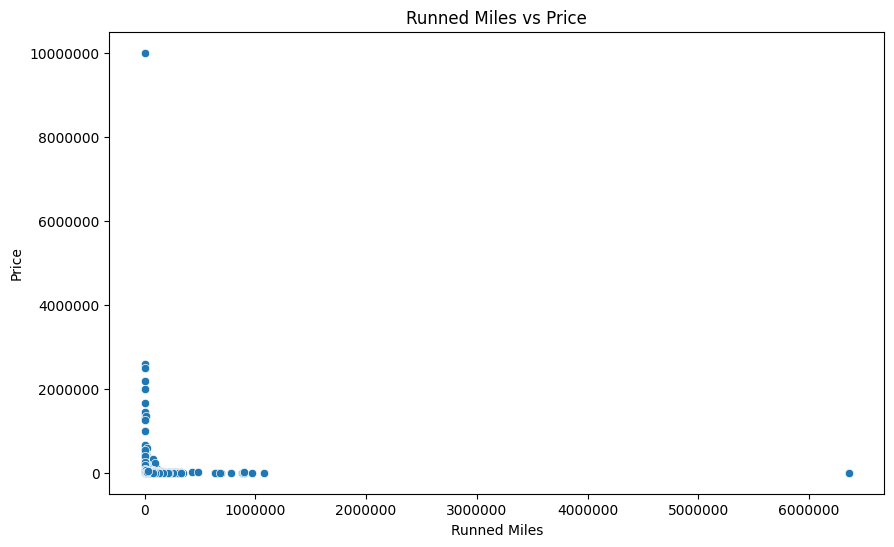

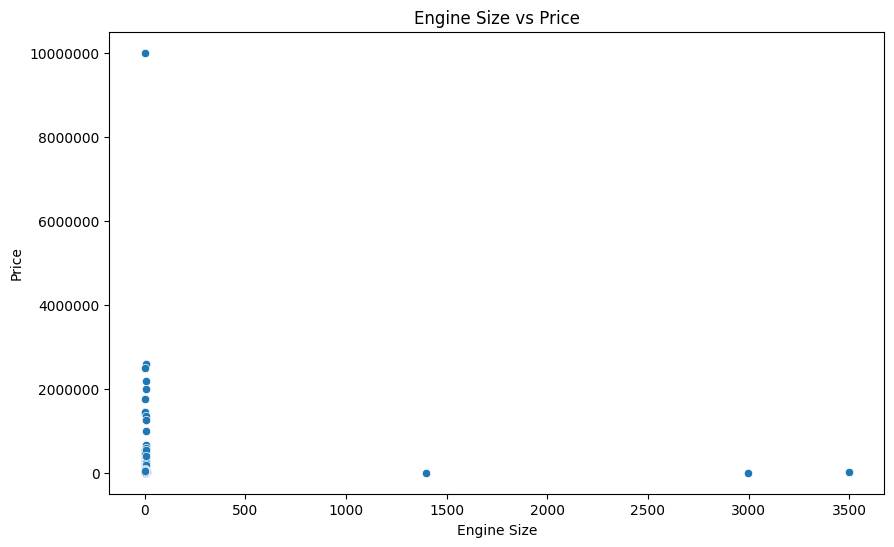

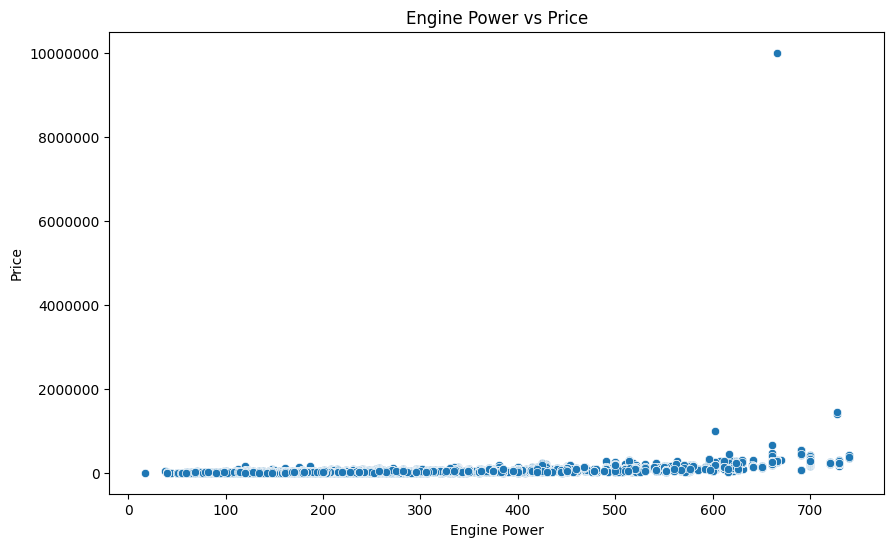

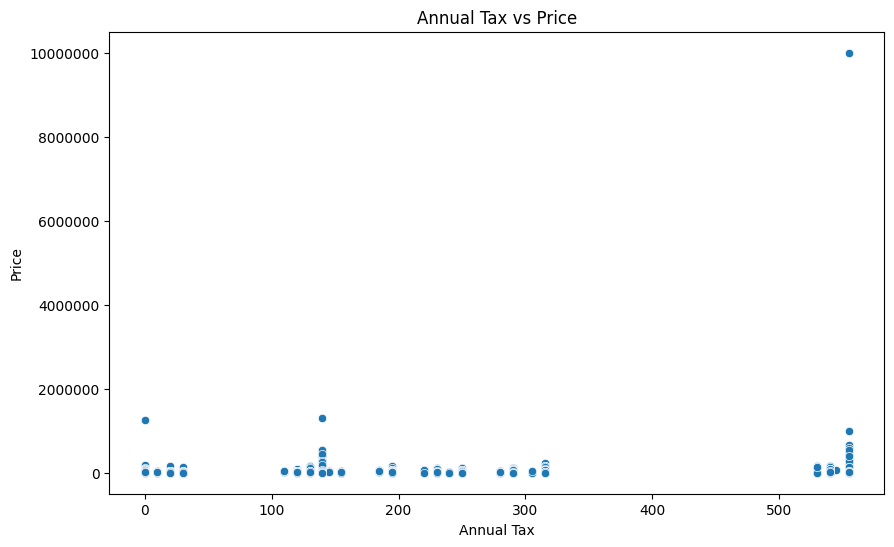

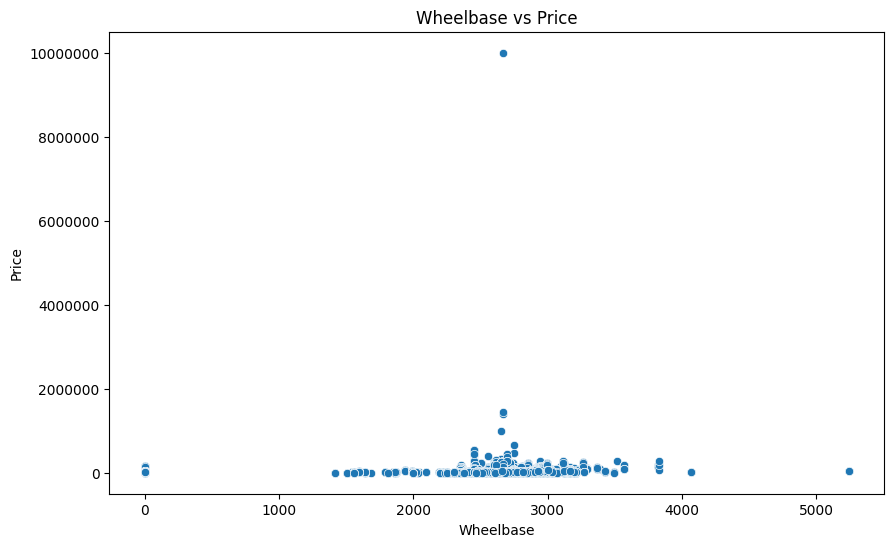

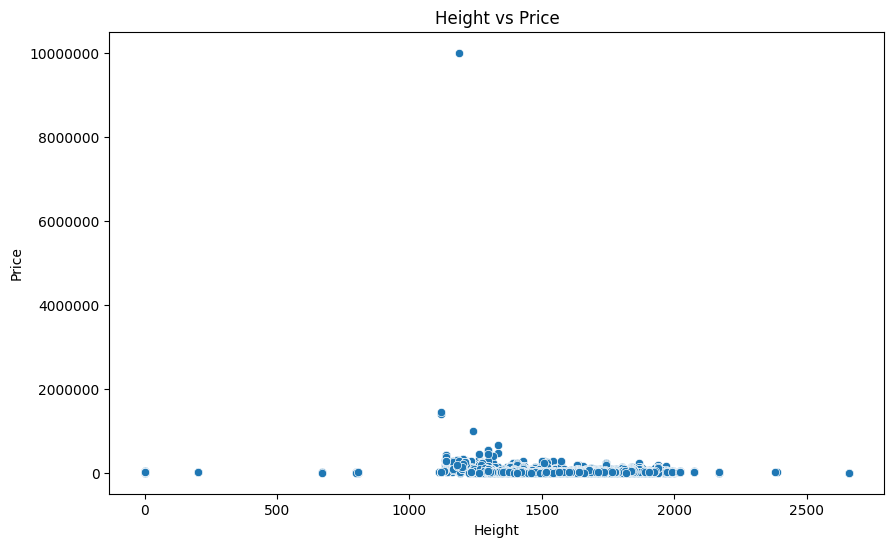

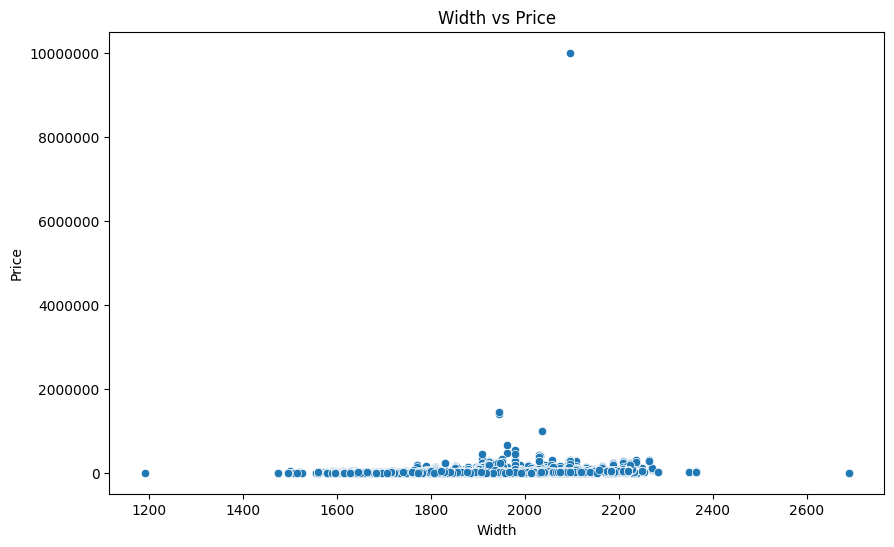

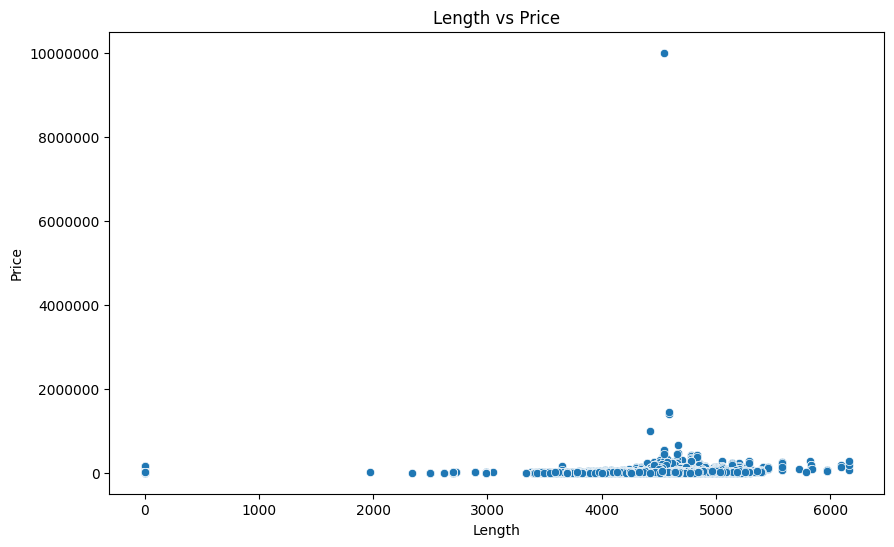

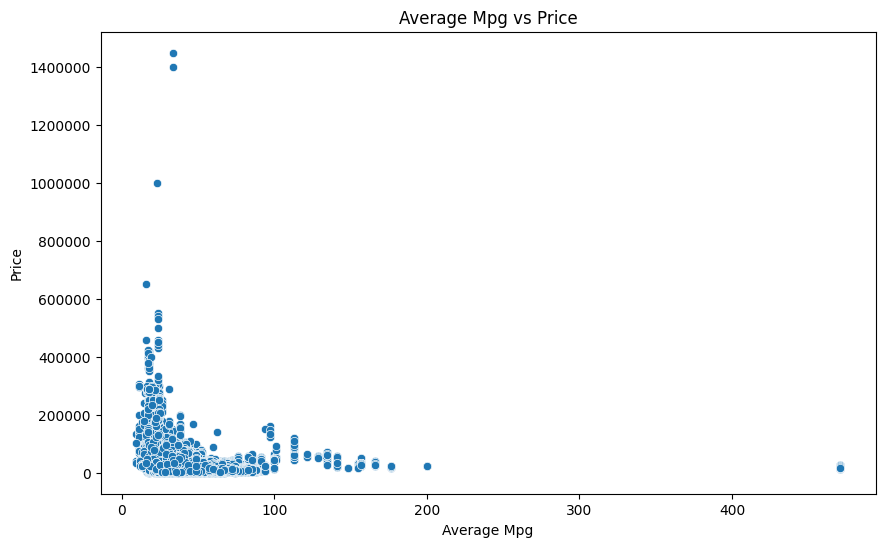

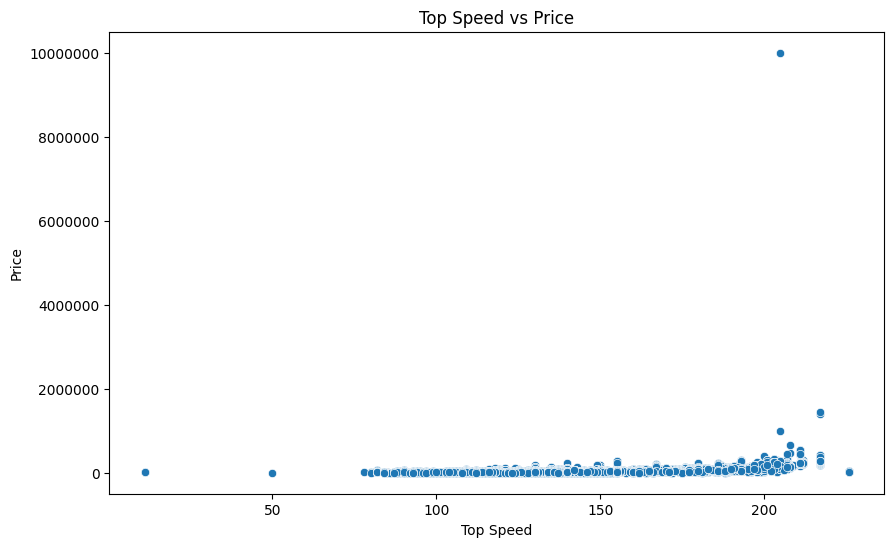

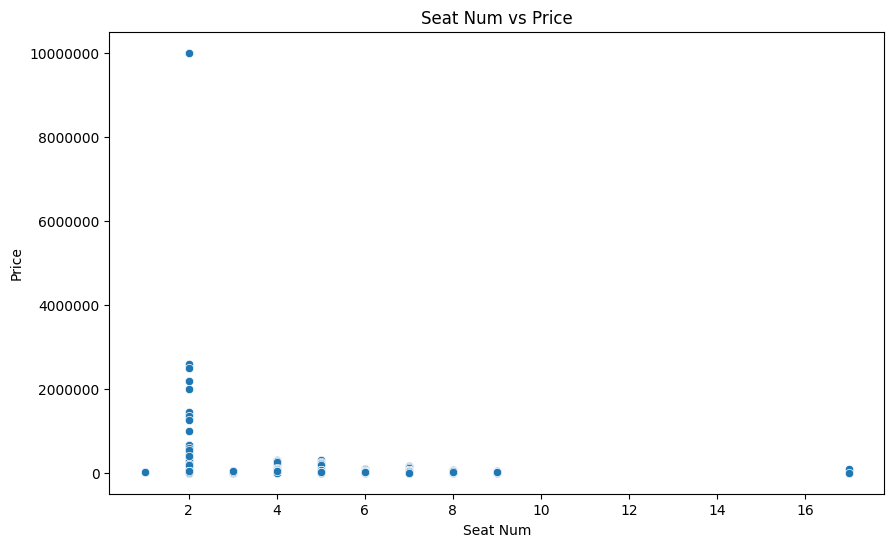

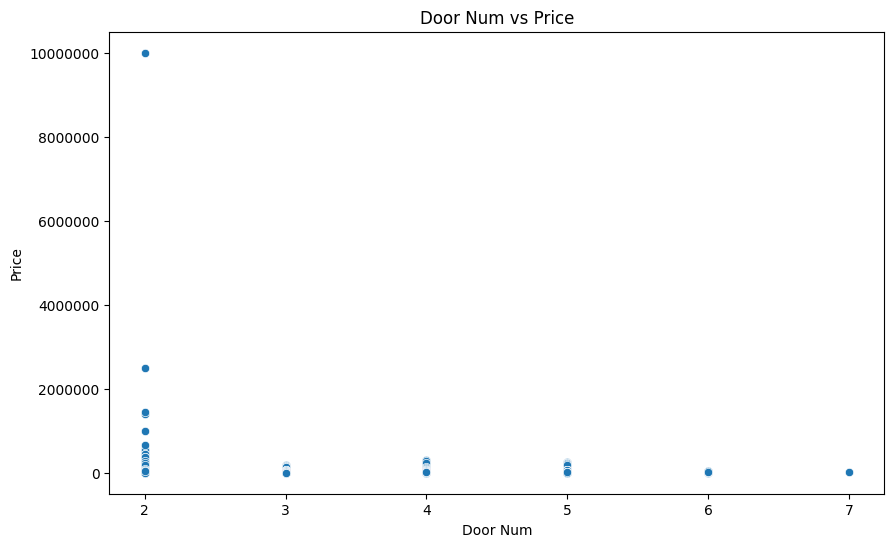

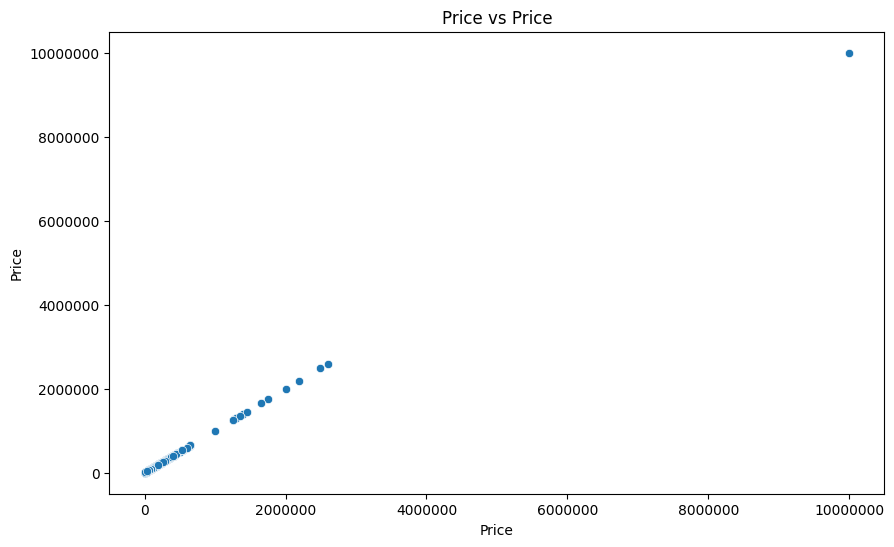

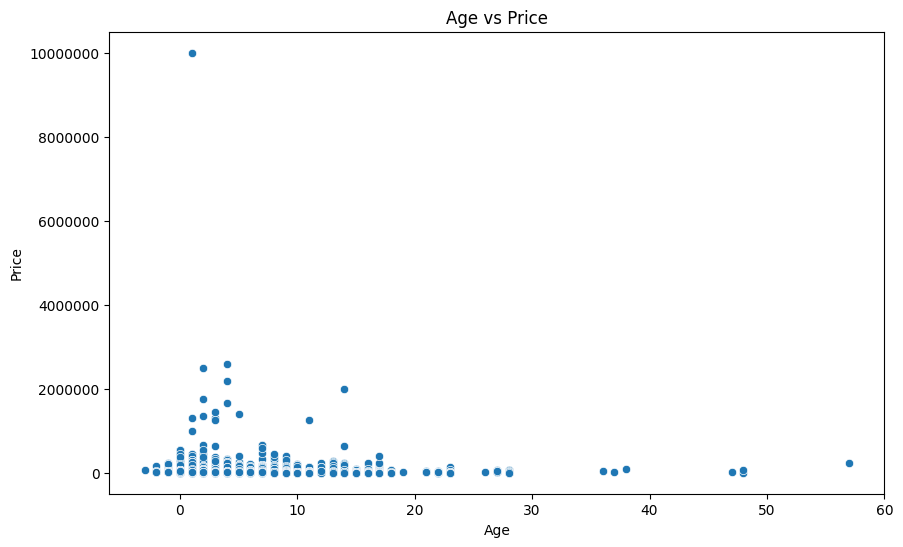

In [26]:
for column in tmp.select_dtypes(include=['float64', 'int64']).columns:
    lower_bound = np.percentile(tmp[column], 1)  # tinh de bo outlier
    upper_bound = np.percentile(tmp[column], 95)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=tmp, x=column, y='Price')
    plt.title(f"{column.replace('_', ' ').title()} vs Price")
    if not (np.isnan(lower_bound) or np.isnan(upper_bound)):
      plt.xlim(lower_bound, upper_bound)
    plt.ticklabel_format(axis='both', style='plain')
    plt.xlabel(column.replace('_', ' ').title())
    plt.ylabel("Price")
    plt.show()

Ta thấy:
- Adv_year, Adv_month, Height, Wheelbase có độ tương quan rất kém với giá xe, có thể loại bỏ
- Annual_Tax và Door_Num không tuyến tính với


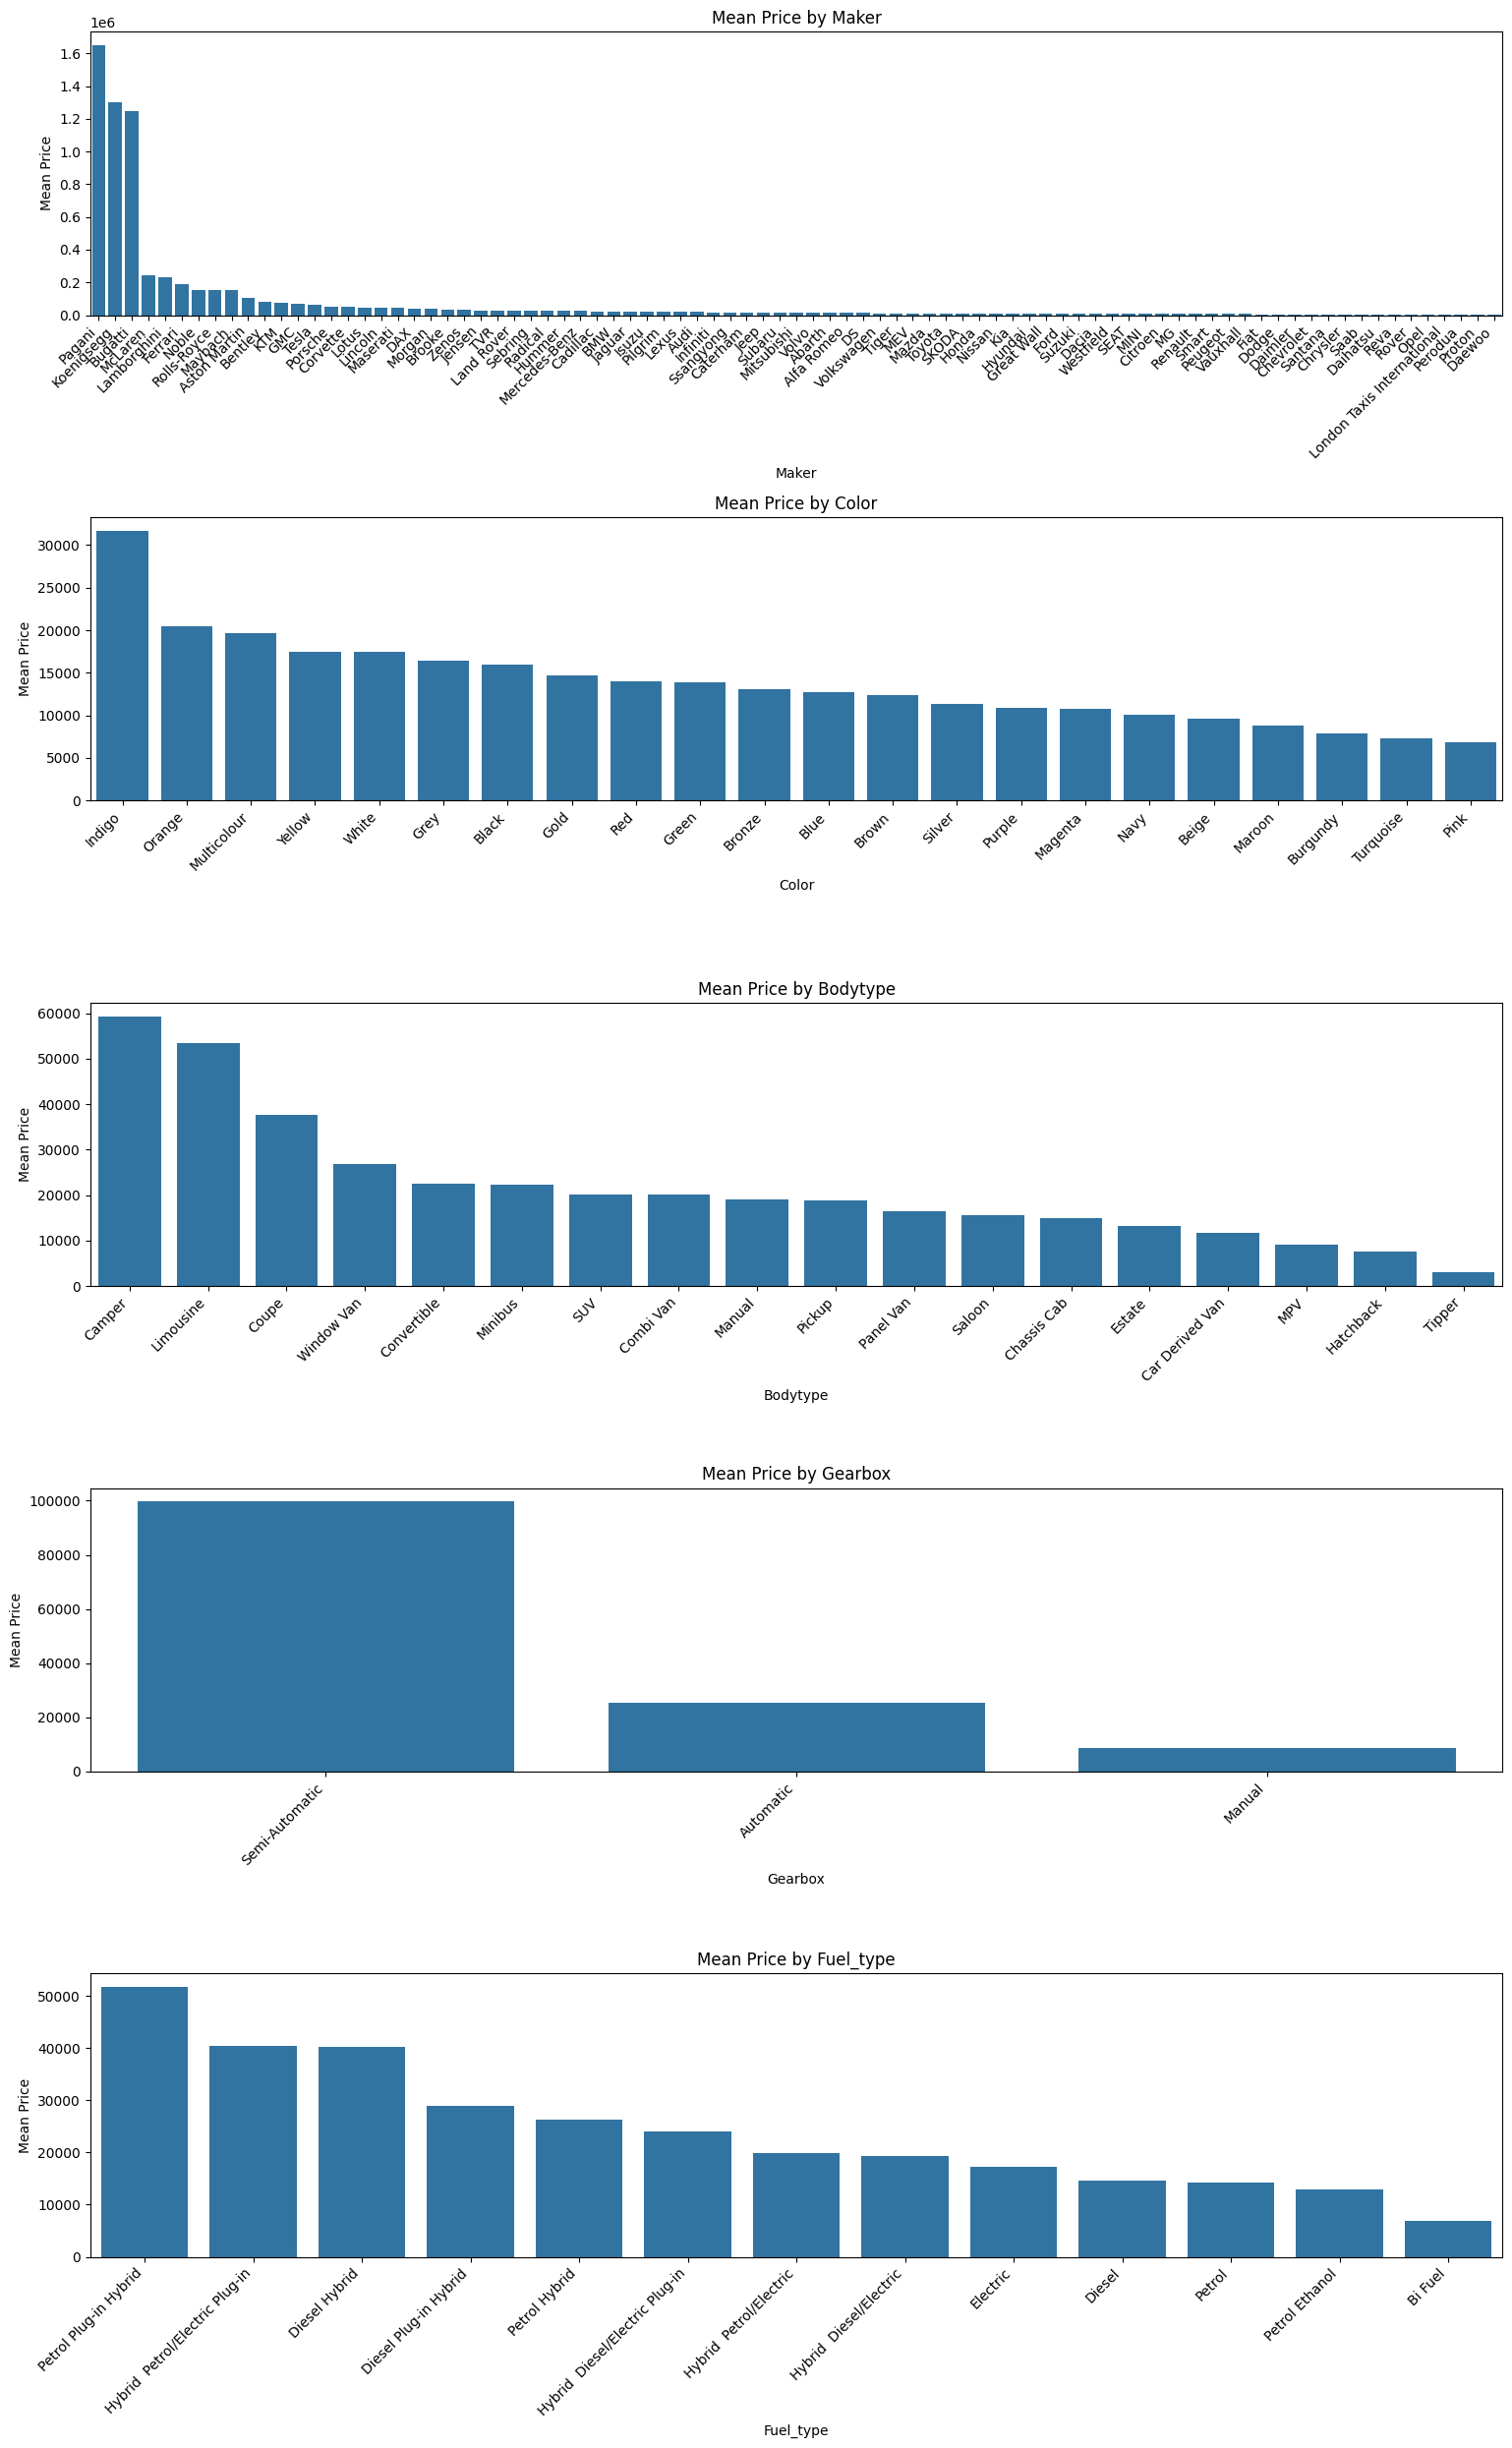

In [27]:
# Biến phân loại vs giá xe

categorical_cols_to_plot = []
for col in x_train.columns:
    if x_train[col].dtype == 'object' and x_train[col].nunique() < 100:
        categorical_cols_to_plot.append(col)

data_for_plotting = x_train.copy()
data_for_plotting['Price'] = y_train


plt.figure(figsize=(30, 5 * len(categorical_cols_to_plot)))

for i, col in enumerate(categorical_cols_to_plot):

    plt.subplot(len(categorical_cols_to_plot), 2, 2*i + 2)
    mean_price = data_for_plotting.groupby(col)['Price'].mean().sort_values(ascending=False)
    sns.barplot(x=mean_price.index, y=mean_price.values)
    plt.title(f'Mean Price by {col}')
    plt.xlabel(col)
    plt.ylabel('Mean Price')
    plt.xticks(rotation=45, ha='right') # Xoay nhãn

plt.tight_layout() # Điều chỉnh layout để tránh chồng chéo
plt.show()


### 4) Kiểm định dữ liệu - Data Validation

#### Định nghĩa schema
Dựa vào dataset và phần EDA bên trên, ta có thể xây dựng 1 schema như sau:

```
===== S C H E M A =====
===> Format (tên cột - định nghĩa - kiểu dữ liệu (trước và sau encode) - miền giá trị)

> maker (categorical):
    - Tên nhà sản xuất ô tô.
    - string_object => float64 (x >= 0) target encoding
    - Nếu OOV/NaN: Gán trung bình giá xe của tập train

> color (categorical):
    - Màu sắc ô tô
    - string_object => float64 (x >= 0) target encoding
    - Nếu OOV/NaN: Gán trung bình giá xe của màu phổ biến nhất

> age:
   - Tuổi thọ xe: (reg_year - adv_year)
   - int64 (x > 0)
   - Nếu OOV/NaN: Gán tuổi thọ trung bình trên tập train

> bodytype (categorical):
   - Kiểu thân xe
   - string_object => float64 (x >= 0): one hot encoding
   - Nếu OOV/NaN: Gán trung bình giá xe có kiểu thân xe phổ biến nhất

> runned-miles:
   - Số dặm đi được
   - int64 (x >= 0)
   - Nếu OOV/NaN: gán trung bình dặm đi được

> engine-size:
   - Dung tích động cơ
   - float64 (x > 0)
   - Nếu OOV/NaN: gán trung bình dung tích động cơ

> gearbox (categorical):
   - Loại hộp số (số chủng loại tương đối nhỏ)
   - string_object => int64 (x >= 0): one hot encoding
   - Nếu OOV/NaN: gán mode hộp số

> fuel-type (categorial):
   - Loại nhiên liệu
   - string_object => int64 (x > 0): one hot
   - Nếu OOV/NaN: gán mode

> engine-power:
   - Mã lực
   - int64 (x > 0)
   - Nếu OOV/NaN: gán median

> width:
   - Chiều rộng
   - float64 (x > 0)
   - Nếu OOV/NaN: gán median

> length:
   - Chiều rộng
   - float64 (x > 0)
   - Nếu OOV/NaN: gán median

> average-mpg:
   - Số dặm đi được trên một gallon nhiên liệu
   - float64 (x > 0)
   - Nếu OOV/NaN: gán median

> top-speeed:
   - Tốc độ tối đa (miles)
   - float64 (x > 0)
   - Nếu OOV/NaN: gán median

> seat-num:
   - Số chỗ ngồi
   - int64 (x > 0)
   - Nếu OOV/NaN: gán mode

```

#### Kiểm định

In [28]:
# Kiểm tra số lượng giá trị độc nhất để xem xét cách encode chủng loại

unique_counts = x_train.nunique()

data_types = y_train.dtypes

mydf = pd.DataFrame({
    'Unique_Count': unique_counts,
    'Data_Type': data_types
})

# số lượng giá trị độc nhất của các cột phân loại tương đối nhiều, xem xét loại bỏ hoặc tìm các encode nhưng tránh để dữ liệu có sparsity quá cao :(
mydf

,Unique_Count,Data_Type
Maker,85,float64
Genmodel,865,float64
Genmodel_ID,850,float64
Adv_ID,214604,float64
Adv_year,10,float64
Adv_month,15,float64
Color,22,float64
Reg_year,25,float64
Bodytype,18,float64
Runned_Miles,64485,float64


In [29]:
# Kiểm tra giá xe có tuân theo phân phối chuẩn không


from scipy.stats import shapiro

# stat_m, p_m = shapiro(np.log(y_train.dropna()))
stat_m, p_m = shapiro(y_train.dropna())

print(f"p-value = {p_m}")

for p in [p_m]:
    if p > 0.05:
        print("Dữ liệu phân phối chuẩn")
    else:
        print("Dữ liệu KHÔNG phân phối chuẩn :(((")



p-value = 1.2503946835670502e-196
Dữ liệu KHÔNG phân phối chuẩn :(((


d:\code stuffs\Python\vietai-project-tmp\car-price-prediction-dvm\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 213679.
  res = hypotest_fun_out(*samples, **kwds)


In [30]:
# Khảo sát số lượng, tỷ lệ các ô NaN và giá trị 0

def count_nan_zero_ratio(df):
    total_rows = len(df)

    nan_counts = df.isna().sum()
    nan_ratios = (nan_counts / total_rows).round(3)*100

    zero_counts = (df == 0).sum(numeric_only=True)
    zero_ratios = (zero_counts / total_rows).round(3)*100

    result = pd.DataFrame({
        'nan_count': nan_counts,
        'nan_ratio (%)': nan_ratios,
        'zero_count': zero_counts,
        'zero_ratio (%)': zero_ratios
    })

    return result.sort_values(by='nan_ratio (%)', ascending=False).reset_index(drop=False)

count_nan_zero_ratio(x_train)

,index,nan_count,nan_ratio (%),zero_count,zero_ratio (%)
0,Annual_Tax,38137,17.8,11272,5.3
1,Top_speed,35015,16.3,0,0.0
2,Average_mpg,33639,15.7,0,0.0
3,Engine_power,25482,11.9,0,0.0
4,Width,22519,10.5,0,0.0
5,Wheelbase,22455,10.5,5958,2.8
6,Height,22294,10.4,757,0.4
7,Length,22294,10.4,68,0.0
8,Color,17513,8.2,0,0.0
9,Seat_num,5246,2.4,0,0.0


Ta thấy:
- 7 dòng đầu tỉ lệ NaN khá cao (> 10%), có thể cân nhắc loại bỏ một số cột không quan trọng hay điền vào những cột quan trọng
- Các dòng tỉ lệ NaN < 10% có thể điền giá trị vào.
- Cột 5, 6, 7, 10 có xuất hiện giá trị 0, vô lí so với tên của đặc trưng nhưng số lượng tương đối nhỏ, có thể điền giá trị.



### 5) Data Preparation & Feature Engineering

In [31]:
from math import nan
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder

# sore to the eye
class DataPreparation ():
  def __init__ (self, x_train, y_train):

    self.kept_feature_names = ['Maker', 'Color', 'Bodytype', 'Runned_Miles', 'Engine_size', 'Gearbox', 'Fuel_type', 'Engine_power', 'Width', 'Length', 'Average_mpg', 'Top_speed', 'Seat_num', 'Age']
    self.new_column_names = ['maker', 'color', 'bodytype', 'runned-miles', 'engine-size', 'gearbox', 'fuel-type', 'engine-power', 'width', 'length', 'average-mpg', 'top-speed', 'seat-num', 'age']
    self.dropped_rows_nan = ['top-speed', 'average-mpg', 'engine-power', 'width', 'length']

    self.x_train = x_train # x chi moi sau khi qua light cleaning
    self.y_train = y_train
    self.encoders = {}

    self.fit_age = {
        'mode_reg': self.x_train['Reg_year'].mode()[0],
        'mode_adv': self.x_train['Adv_year'].mode()[0]
    }
    self.fit_df = []


  # THEM DAC TRUNG AGE = REG_YEAR - ADV_YEAR
  def addFeatureAge (self, df): # inplace = true

    df['Reg_year'].fillna({col: self.fit_age['mode_reg']}, inplace = True)
    df['Adv_year'].fillna({col: self.fit_age['mode_adv']}, inplace = True)

    df['Reg_year'].astype('Int64')
    df['Adv_year'].astype('Int64')

    df['Age'] = df['Adv_year'] - df['Reg_year']

    self.x_train = []
    return df

  # BO DONG DOI TEN COT
  def removeAndRenameCols (self, df): # inplace = false

    df = df[self.kept_feature_names]
    df = df.rename(columns = dict(zip(self.kept_feature_names, self.new_column_names)))

    return df

  # DROP CAC MAU CO NAN
  def dropCols (self, df, labels = []): # inplace = false
    print("Số lượng mẫu trước khi drop: ", df.shape[0])

    # drop mau co dac trung co nan
    df.dropna(inplace=True, subset = self.dropped_rows_nan)
    labels = labels.loc[df.index]


    df = df.reset_index(drop = True)
    labels = labels.reset_index(drop = True)

    print("Số lượng mẫu sau khi drop: ", df.shape[0])
    return (df, labels)

  def dropPriceNaN (self, x, y):
    nan_indices = y.isnull()

    x_cleaned = pd.DataFrame(x[~nan_indices].reset_index(drop=True))
    y_cleaned = pd.Series(y[~nan_indices].reset_index(drop=True))


    return (x_cleaned, y_cleaned)



  # DIEN KHUYET VA EP KIEU DU LIEU
  def FitTransformImputeAndConvert (self, df, y_train, schema): # inplace = true
    self.y_train = y_train
    self.fit_df = df.copy()
    for feature in schema.values:
      if feature[2] == 'none':
        df = self.handleContinuousFeature(df, feature, df)
      else:
        df = self.handleDiscreteFeatures(df, feature, df)

    return pd.DataFrame(df)

  def TransformImputeAndConvert (self, df, y_train, schema): # inplace = true
    self.y_train = y_train
    for feature in schema.values:
      if feature[2] == 'none':
        df = self.handleContinuousFeature(df, feature)
      else:
        df = self.handleDiscreteFeatures(df, feature)

    return pd.DataFrame(df)

  def handleContinuousFeature(self, df, feature, fit_df = None):
    if (fit_df is None):
      fit_df = self.fit_df

    df[feature[0]] = pd.to_numeric(df[feature[0]], errors='coerce')
    df[feature[0]] = df[feature[0]].astype(feature[1])

    if feature[3] == 'mean':
      df[feature[0]] = df[feature[0]].fillna(fit_df[feature[0]].mean())
    elif feature[3] == 'median':
      df[feature[0]] = df[feature[0]].fillna(fit_df[feature[0]].median())
    elif feature[3] == 'mode':
      df[feature[0]] = df[feature[0]].fillna(fit_df[feature[0]].mode()[0])


    return df

  def handleDiscreteFeatures(self, df, feature, fit_df = None):
    if (fit_df is None):
      fit_df = self.fit_df

    name = feature[0]
    typetobe = feature[1]
    encode_method = feature[2]
    impute_method = feature[3]
    prices = self.y_train # trainnnnn

    if impute_method == 'mode':
      modes = fit_df[name].mode()
      if modes[0] is nan:
        df[name].fillna(fit_df[name].mode()[1])
      else:
        df[name].fillna(fit_df[name].mode()[0])

    if encode_method == 'target':
      encoder = TargetEncoder(cols=[name], handle_unknown='value', smoothing = 0.1)
      encoder.fit(fit_df[name], prices)
      df[name] = encoder.transform(df[[name]])[name]

    elif encode_method == 'one-hot':
      encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
      encoder.fit(fit_df[[name]])

      encoded_data = encoder.transform(df[[name]])
      new_col_names = encoder.get_feature_names_out([name])

      encoded_df_part = pd.DataFrame(encoded_data, columns=new_col_names, index=df.index)
      df_tmp = df.drop(columns=[name], inplace=False)
      df = pd.concat([df_tmp, encoded_df_part], axis=1)

    if impute_method == 'mean':
      df[name].fillna(prices.mean())

    return df





In [32]:
DataPreparator = DataPreparation(x_train, y_train) # raw

#### Thêm đặc trưng 'Age'

In [33]:
DataPreparator.addFeatureAge(x_train)
DataPreparator.addFeatureAge(x_val)
DataPreparator.addFeatureAge(x_test)

x_train.head()

C:\Users\ACER\AppData\Local\Temp\ipykernel_22672\913874095.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Reg_year'].fillna({col: self.fit_age['mode_reg']}, inplace = True)
C:\Users\ACER\AppData\Local\Temp\ipykernel_22672\913874095.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves

,Maker,Genmodel,Genmodel_ID,Adv_ID,Adv_year,Adv_month,Color,Reg_year,Bodytype,Runned_Miles,...,Annual_Tax,Wheelbase,Height,Width,Length,Average_mpg,Top_speed,Seat_num,Door_num,Age
0,Mercedes-Benz,GLE Class,59_25,59_25$$373,2021,5,White,2019.0,Coupe,4987.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,2.0
1,Vauxhall,Corsa,94_9,94_9$$3352,2018,8,Black,2015.0,Hatchback,35345.0,...,0.0,2510.0,1481.0,1944.0,4021.0,83.1,113.0,5.0,5.0,3.0
2,Nissan,350 Z,64_1,64_1$$57,2018,8,NaN,2005.0,Coupe,64000.0,...,NaN,2650.0,1320.0,1815.0,4310.0,24.8,155.0,2.0,2.0,13.0
3,Ford,Fiesta,29_13,29_13$$1409,2018,8,Blue,2007.0,Hatchback,104155.0,...,250.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0,11.0
4,Ford,C-Max,29_2,29_2$$689,2018,5,Black,2012.0,MPV,71000.0,...,30.0,2850.0,1626.0,2067.0,4380.0,61.4,114.0,5.0,5.0,6.0


#### Loại bỏ đặc trưng không cần thiết và sửa lại tên cột

In [34]:
x_train = DataPreparator.removeAndRenameCols(x_train)
x_val = DataPreparator.removeAndRenameCols(x_val)
x_test = DataPreparator.removeAndRenameCols(x_test)

x_train.head()

,maker,color,bodytype,runned-miles,engine-size,gearbox,fuel-type,engine-power,width,length,average-mpg,top-speed,seat-num,age
0,Mercedes-Benz,White,Coupe,4987.0,3.0,Automatic,Diesel,NaN,NaN,NaN,NaN,NaN,5.0,2.0
1,Vauxhall,Black,Hatchback,35345.0,1.3,Manual,Diesel,94.0,1944.0,4021.0,83.1,113.0,5.0,3.0
2,Nissan,NaN,Coupe,64000.0,3.5,Manual,Petrol,276.0,1815.0,4310.0,24.8,155.0,2.0,13.0
3,Ford,Blue,Hatchback,104155.0,2.0,Manual,Petrol,NaN,NaN,NaN,NaN,NaN,5.0,11.0
4,Ford,Black,MPV,71000.0,1.6,Manual,Diesel,113.0,2067.0,4380.0,61.4,114.0,5.0,6.0


#### Drop mẫu

In [35]:
# Drop trong x_train theo x_train, drop trong y_train theo x_train

x_train, y_train = DataPreparator.dropCols(x_train, y_train)
x_val, y_val = DataPreparator.dropCols(x_val, y_val)

# x_test, y_test = DataPreparator.dropCols(x_test, y_test)

# print(x_train.shape[0], y_train.shape[0])

Số lượng mẫu trước khi drop:  214604
Số lượng mẫu sau khi drop:  174866
Số lượng mẫu trước khi drop:  26825
Số lượng mẫu sau khi drop:  21948


In [36]:
# Drop trong x_train neu y_train co NaN

x_train, y_train = DataPreparator.dropPriceNaN(x_train, y_train)
x_val, y_val = DataPreparator.dropPriceNaN(x_val, y_val)
x_test, y_test = DataPreparator.dropPriceNaN(x_test, y_test)


#### Điền khuyết

In [37]:
count_nan_zero_ratio(x_train)

,index,nan_count,nan_ratio (%),zero_count,zero_ratio (%)
0,color,14315,8.2,0,0.0
1,seat-num,1268,0.7,0,0.0
2,runned-miles,606,0.3,0,0.0
3,bodytype,101,0.1,0,0.0
4,engine-size,75,0.0,0,0.0
5,maker,0,0.0,0,0.0
6,gearbox,0,0.0,0,0.0
7,fuel-type,0,0.0,0,0.0
8,width,0,0.0,0,0.0
9,engine-power,0,0.0,0,0.0


In [38]:
# Kiểm tra số lượng giá trị độc nhất để xem xét cách encode chủng loại

unique_counts = x_train.nunique()

data_types = y_train.dtypes

mydf = pd.DataFrame({
    'Unique_Count': unique_counts,
    'Data_Type': data_types
})

# số lượng giá trị độc nhất của các cột phân loại tương đối nhiều, xem xét loại bỏ hoặc tìm các encode nhưng tránh để dữ liệu có sparsity quá cao :(
mydf

,Unique_Count,Data_Type
maker,58,float64
color,22,float64
bodytype,14,float64
runned-miles,58194,float64
engine-size,61,float64
gearbox,2,float64
fuel-type,9,float64
engine-power,444,float64
width,457,float64
length,951,float64


In [39]:
# ten cot - dtype - cach encode [neu la chung loai] - cac xu li imputatio
carSchema = pd.DataFrame([
    ['age', 'Float64', 'none', 'mean'],
    ['runned-miles', 'Float64', 'none', 'mean'],
    ['engine-size', 'Float64', 'none', 'mean'],
    ['engine-power', 'Float64', 'none', 'median'],
    ['width', 'Float64', 'none', 'median'],
    ['length', 'Float64', 'none', 'median'],
    ['average-mpg', 'Float64', 'none', 'median'],
    ['top-speed', 'Float64', 'none', 'median'],
    ['seat-num', 'Float64', 'none', 'mode'],
    ['maker', 'Float64', 'target', 'mean'], # encode first
    ['color', 'Float64', 'target', 'mode'],
    ['bodytype', 'Float64', 'one-hot', 'mode'],
    ['gearbox', 'Float64', 'one-hot', 'mode'],
    ['fuel-type', 'Float64', 'one-hot', 'mode'],
])

In [40]:
x_train = DataPreparator.FitTransformImputeAndConvert(x_train, y_train, carSchema)# THIS ICKS


In [41]:
x_train

,maker,color,runned-miles,engine-size,engine-power,width,length,average-mpg,top-speed,seat-num,...,gearbox_Manual,fuel-type_Bi Fuel,fuel-type_Diesel,fuel-type_Electric,fuel-type_Hybrid Diesel/Electric,fuel-type_Hybrid Diesel/Electric Plug-in,fuel-type_Hybrid Petrol/Electric,fuel-type_Hybrid Petrol/Electric Plug-in,fuel-type_Petrol,fuel-type_Petrol Ethanol
0,6354.626243,14205.256269,35345.0,1.3,94.0,1944.0,4021.0,83.1,113.0,5.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8747.015776,14253.221795,64000.0,3.5,276.0,1815.0,4310.0,24.8,155.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,7723.185660,14205.256269,71000.0,1.6,113.0,2067.0,4380.0,61.4,114.0,5.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10351.986869,11370.735012,14623.0,2.0,148.0,2081.0,4854.0,54.3,123.0,7.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10201.971088,14253.221795,20.0,2.0,118.0,1765.0,4275.0,47.9,119.0,5.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174861,6199.571557,14253.221795,49000.0,1.6,120.0,1683.0,3699.0,48.7,123.0,4.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
174862,9411.652802,16226.372606,21154.0,1.8,98.0,1760.0,4245.0,72.4,112.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
174863,12567.701994,14253.221795,37750.0,2.4,220.0,2119.0,4838.0,48.7,130.0,5.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174864,6979.155051,14205.256269,78000.0,1.6,90.0,1773.0,4260.0,64.2,112.0,5.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
x_val = DataPreparator.TransformImputeAndConvert(x_val, y_train, carSchema)
x_test = DataPreparator.TransformImputeAndConvert(x_test, y_train, carSchema)

#### Chuấn hóa dữ liệu

In [43]:
### STANDARDR SCALER (Z SCORE NORMALIZATION)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)

,copy,True
,with_mean,True
,with_std,True


In [44]:
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)


In [45]:
x_train

array([[-0.50426612,  0.47523958, -0.34825691, ..., -0.04368007,
        -0.97726924, -0.00585774],
       [-0.32742711,  0.49744704,  0.31536833, ..., -0.04368007,
         1.02325946, -0.00585774],
       [-0.40310588,  0.47523958,  0.47748234, ..., -0.04368007,
        -0.97726924, -0.00585774],
       ...,
       [-0.04501224,  0.49744704, -0.29255918, ..., -0.04368007,
        -0.97726924, -0.00585774],
       [-0.45810263,  0.47523958,  0.63959634, ..., -0.04368007,
        -0.97726924, -0.00585774],
       [ 2.32420586, -0.83711005, -0.39098553, ..., -0.04368007,
         1.02325946, -0.00585774]])

## II) Giai đoạn xây dựng mô hình

### 1) Linear Regression

#### Linear Regression với Tensorflow

In [46]:
# w3s hehe
x_train = np.array(x_train)
x_train.shape

(174866, 37)

In [47]:
y_train = np.array(y_train).reshape([-1, 1])
y_train.shape

(174866, 1)

In [48]:
learning_rate = 0.01
epochs = 100
num_features = x_train.shape[1]
batch_size = 1048

In [49]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = (num_features,)), # shape là số đặc trưng
    tf.keras.layers.Dense(units=1) # units là số output cho 1 mẫu
])

In [50]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │            38 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38 (152.00 B)

 Trainable params: 38 (152.00 B)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Cấu hình quá trình huấn luyện
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
    loss='mse'
)

In [52]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
  monitor='val_loss',
  patience= 7,
  restore_best_weights=True,
  verbose=0,
)

In [53]:
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=2,
    callbacks=[early_stopping_callback],
    validation_split=0.2
)

Epoch 1/100
134/134 - 2s - 12ms/step - loss: 175476592.0000 - val_loss: 88409896.0000
Epoch 2/100
134/134 - 1s - 5ms/step - loss: 115198000.0000 - val_loss: 86633368.0000
Epoch 3/100
134/134 - 1s - 5ms/step - loss: 112698104.0000 - val_loss: 84162112.0000
Epoch 4/100
134/134 - 1s - 5ms/step - loss: 111492896.0000 - val_loss: 83568944.0000
Epoch 5/100
134/134 - 1s - 5ms/step - loss: 110572640.0000 - val_loss: 83253896.0000
Epoch 6/100
134/134 - 1s - 5ms/step - loss: 109815016.0000 - val_loss: 82339552.0000
Epoch 7/100
134/134 - 1s - 5ms/step - loss: 109310432.0000 - val_loss: 81885576.0000
Epoch 8/100
134/134 - 1s - 5ms/step - loss: 108884408.0000 - val_loss: 81692968.0000
Epoch 9/100
134/134 - 1s - 5ms/step - loss: 108514120.0000 - val_loss: 81375616.0000
Epoch 10/100
134/134 - 1s - 5ms/step - loss: 108355880.0000 - val_loss: 81318512.0000
Epoch 11/100
134/134 - 1s - 5ms/step - loss: 108101128.0000 - val_loss: 81541224.0000
Epoch 12/100
134/134 - 1s - 5ms/step - loss: 107905536.0000 - 

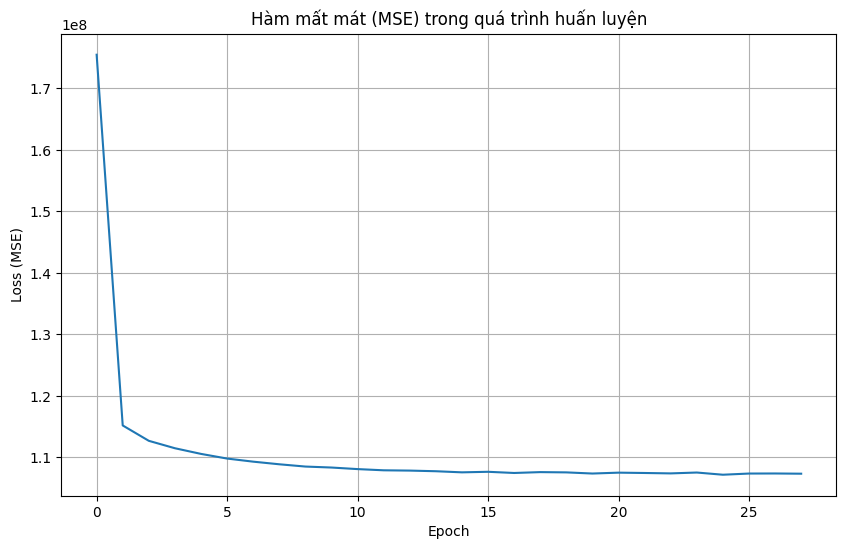

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.title('Hàm mất mát (MSE) trong quá trình huấn luyện')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.show()

In [55]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [56]:
y_train_pred = model.predict(x_train)

mse = mean_squared_error(y_train, y_train_pred)
print(f"MSE trên tập train: {mse:.4f}")

rmse = np.sqrt(mse)
print(f"RMSE trên tập train: {rmse:.4f}")

mae = mean_absolute_error(y_train, y_train_pred)
print(f"MAE trên tập train: {mae:.4f}")

r2 = r2_score(y_train, y_train_pred)
print(f"R-squared trên tập train: {r2:.4f}")


std = y_train.std()
print(f"Độ lệch chuẩn của y_train: {std:.4f}")

5465/5465 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
MSE trên tập train: 101754971.1271
RMSE trên tập train: 10087.3669
MAE trên tập train: 4528.6375
R-squared trên tập train: 0.7268
Độ lệch chuẩn của y_train: 19298.8818


In [57]:
y_val_pred = model.predict(x_val)


mse = mean_squared_error(y_val, y_val_pred)
print(f"MSE trên tập validion: {mse:.4f}")

val_rmse = np.sqrt(mse)
print(f"RMSE trên tập validation: {val_rmse:.4f}")

val_mae = mean_absolute_error(y_val, y_val_pred)
print(f"MAE trên tập validation: {val_mae:.4f}")

val_r2 = r2_score(y_val, y_val_pred)
print(f"R-squared trên tập validation: {val_r2:.4f}")

std = y_val.std()
print(f"Độ lệch chuẩn của validation: {std:.4f}")

686/686 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
MSE trên tập validion: 217134230.0034
RMSE trên tập validation: 14735.4752
MAE trên tập validation: 4584.0233
R-squared trên tập validation: 0.5836
Độ lệch chuẩn của validation: 22835.5961


#### Linear Regression với L2 regularization (Ridge)

In [58]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=1.0)

ridge_model.fit(x_train, y_train)

y_train_pred_ridge = ridge_model.predict(x_train)
y_val_pred_ridge = ridge_model.predict(x_val)

print("===== Đánh giá trên tập huấn luyện (Ridge) =====")
mse_train_ridge = mean_squared_error(y_train, y_train_pred_ridge)
rmse_train_ridge = np.sqrt(mse_train_ridge)
mae_train_ridge = mean_absolute_error(y_train, y_train_pred_ridge)
r2_train_ridge = r2_score(y_train, y_train_pred_ridge)

print(f"MSE trên tập train: {mse_train_ridge:.4f}")
print(f"RMSE trên tập train: {rmse_train_ridge:.4f}")
print(f"MAE trên tập train: {mae_train_ridge:.4f}")
print(f"R-squared trên tập train: {r2_train_ridge:.4f}")


print("\n===== Đánh giá trên tập validation (Ridge) =====")
mse_val_ridge = mean_squared_error(y_val, y_val_pred_ridge)
rmse_val_ridge = np.sqrt(mse_val_ridge)
mae_val_ridge = mean_absolute_error(y_val, y_val_pred_ridge)
r2_val_ridge = r2_score(y_val, y_val_pred_ridge)

print(f"MSE trên tập validation: {mse_val_ridge:.4f}")
print(f"RMSE trên tập validation: {rmse_val_ridge:.4f}")
print(f"MAE trên tập validation: {mae_val_ridge:.4f}")
print(f"R-squared trên tập validation: {r2_val_ridge:.4f}")

===== Đánh giá trên tập huấn luyện (Ridge) =====
MSE trên tập train: 101674625.4812
RMSE trên tập train: 10083.3836
MAE trên tập train: 4503.7800
R-squared trên tập train: 0.7270

===== Đánh giá trên tập validation (Ridge) =====
MSE trên tập validation: 216777728.7971
RMSE trên tập validation: 14723.3736
MAE trên tập validation: 4558.5993
R-squared trên tập validation: 0.5843


#### Linear Regression với GridsearchCV

In [59]:
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}

In [60]:
from sklearn.model_selection import GridSearchCV

ridge_model = Ridge()

grid_search = GridSearchCV(ridge_model, param_grid, cv=5) # cv la so k trong k folds cross-validation

In [61]:
grid_search.fit(x_train, y_train)

,estimator,Ridge()
,param_grid,"{'alpha': [0.1, 1.0, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,100.0


In [62]:
best_ridge_model = grid_search.best_estimator_

print("===== Đánh giá trên tập huấn luyện (Best Ridge) =====")
y_train_pred_best_ridge = best_ridge_model.predict(x_train)
mse_train_best_ridge = mean_squared_error(y_train, y_train_pred_best_ridge)
rmse_train_best_ridge = np.sqrt(mse_train_best_ridge)
mae_train_best_ridge = mean_absolute_error(y_train, y_train_pred_best_ridge)
r2_train_best_ridge = r2_score(y_train, y_train_pred_best_ridge)

print(f"MSE trên tập train: {mse_train_best_ridge:.4f}")
print(f"RMSE trên tập train: {rmse_train_best_ridge:.4f}")
print(f"MAE trên tập train: {mae_train_best_ridge:.4f}")
print(f"R-squared trên tập train: {r2_train_best_ridge:.4f}")


print("\n===== Đánh giá trên tập validation (Best Ridge) =====")
y_val_pred_best_ridge = best_ridge_model.predict(x_val)
mse_val_best_ridge = mean_squared_error(y_val, y_val_pred_best_ridge)
rmse_val_best_ridge = np.sqrt(mse_val_best_ridge)
mae_val_best_ridge = mean_absolute_error(y_val, y_val_pred_best_ridge)
r2_val_best_ridge = r2_score(y_val, y_val_pred_best_ridge)

print(f"MSE trên tập validation: {mse_val_best_ridge:.4f}")
print(f"RMSE trên tập validation: {rmse_val_best_ridge:.4f}")
print(f"MAE trên tập validation: {mae_val_best_ridge:.4f}")
print(f"R-squared trên tập validation: {r2_val_best_ridge:.4f}")

===== Đánh giá trên tập huấn luyện (Best Ridge) =====
MSE trên tập train: 101676059.9487
RMSE trên tập train: 10083.4548
MAE trên tập train: 4499.4219
R-squared trên tập train: 0.7270

===== Đánh giá trên tập validation (Best Ridge) =====
MSE trên tập validation: 216811258.2383
RMSE trên tập validation: 14724.5122
MAE trên tập validation: 4554.3198
R-squared trên tập validation: 0.5842


#### **Kết luận**
Sau nhiều bước đổi sửa nhưng kết quả vẫn không cải thiện, ta quyết định chuyển sang mô hình phức tạp hơn

### 2) Mô hình Random Forest Regressor


#### Random Forest Regressor với Scikit Learn

In [63]:
from sklearn.ensemble import RandomForestRegressor


rf_model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1) 

y_train_flat = y_train


print("Bắt đầu huấn luyện Random Forest Regressor...")
rf_model.fit(x_train, y_train_flat)
print("Huấn luyện hoàn tất.")



Bắt đầu huấn luyện Random Forest Regressor...


d:\code stuffs\Python\vietai-project-tmp\car-price-prediction-dvm\.venv\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Huấn luyện hoàn tất.


In [64]:
# Dự đoán trên tập huấn luyện và tập validation
y_train_pred_rf = rf_model.predict(x_train)
y_val_pred_rf = rf_model.predict(x_val)

In [65]:
print("\n===== Đánh giá trên tập huấn luyện (Random Forest) =====")
mse_train_rf = mean_squared_error(y_train_flat, y_train_pred_rf)
rmse_train_rf = np.sqrt(mse_train_rf)
mae_train_rf = mean_absolute_error(y_train_flat, y_train_pred_rf)
r2_train_rf = r2_score(y_train_flat, y_train_pred_rf)

print(f"MSE trên tập train: {mse_train_rf:.4f}")
print(f"RMSE trên tập train: {rmse_train_rf:.4f}")
print(f"MAE trên tập train: {mae_train_rf:.4f}")
print(f"R-squared trên tập train: {r2_train_rf:.4f}")


print("\n===== Đánh giá trên tập validation (Random Forest) =====")
y_val_flat = y_val

mse_val_rf = mean_squared_error(y_val_flat, y_val_pred_rf)
rmse_val_rf = np.sqrt(mse_val_rf)
mae_val_rf = mean_absolute_error(y_val_flat, y_val_pred_rf)
r2_val_rf = r2_score(y_val_flat, y_val_pred_rf)

print(f"MSE trên tập validation: {mse_val_rf:.4f}")
print(f"RMSE trên tập validation: {rmse_val_rf:.4f}")
print(f"MAE trên tập validation: {mae_val_rf:.4f}")
print(f"R-squared trên tập validation: {r2_val_rf:.4f}")



===== Đánh giá trên tập huấn luyện (Random Forest) =====
MSE trên tập train: 1892963.4875
RMSE trên tập train: 1375.8501
MAE trên tập train: 400.0168
R-squared trên tập train: 0.9949

===== Đánh giá trên tập validation (Random Forest) =====
MSE trên tập validation: 32497645.7538
RMSE trên tập validation: 5700.6706
MAE trên tập validation: 1087.0302
R-squared trên tập validation: 0.9377


#### Random Forest Regressor với GridsearchCV

In [69]:
param_grid_rf = {
}

In [70]:
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5)

In [71]:
grid_search_rf.fit(x_train, y_train)

d:\code stuffs\Python\vietai-project-tmp\car-price-prediction-dvm\.venv\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\code stuffs\Python\vietai-project-tmp\car-price-prediction-dvm\.venv\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\code stuffs\Python\vietai-project-tmp\car-price-prediction-dvm\.venv\Lib\site-packages\sklearn\base.py:1363: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\code stuffs\Python\vietai-project-tmp\car-price-pred

,estimator,RandomForestR...ndom_state=42)
,param_grid,{}
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [72]:
# Dự đoán với mô hình tốt nhất từ GridSearchCV
best_rf_model = grid_search_rf.best_estimator_

y_train_pred_rf = best_rf_model.predict(x_train)
y_val_pred_rf = best_rf_model.predict(x_val)
print("\n===== Đánh giá trên tập huấn luyện (Best Random Forest) =====")
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
rmse_train_rf = np.sqrt(mse_train_rf)
mae_train_rf = mean_absolute_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)
print(f"MSE trên tập train: {mse_train_rf:.4f}")
print(f"RMSE trên tập train: {rmse_train_rf:.4f}")
print(f"MAE trên tập train: {mae_train_rf:.4f}")
print(f"R-squared trên tập train: {r2_train_rf:.4f}")

print("\n===== Đánh giá trên tập validation (Best Random Forest) =====")
mse_val_rf = mean_squared_error(y_val, y_val_pred_rf)
rmse_val_rf = np.sqrt(mse_val_rf)
mae_val_rf = mean_absolute_error(y_val, y_val_pred_rf)
r2_val_rf = r2_score(y_val, y_val_pred_rf)
print(f"MSE trên tập validation: {mse_val_rf:.4f}")
print(f"RMSE trên tập validation: {rmse_val_rf:.4f}")
print(f"MAE trên tập validation: {mae_val_rf:.4f}")
print(f"R-squared trên tập validation: {r2_val_rf:.4f}")



===== Đánh giá trên tập huấn luyện (Best Random Forest) =====
MSE trên tập train: 1973965.6981
RMSE trên tập train: 1404.9789
MAE trên tập train: 403.3717
R-squared trên tập train: 0.9947

===== Đánh giá trên tập validation (Best Random Forest) =====
MSE trên tập validation: 33299565.8651
RMSE trên tập validation: 5770.5776
MAE trên tập validation: 1090.4696
R-squared trên tập validation: 0.9361
